# Cone beam computed tomography (CBCT) geometry calibration

## Needed packages

- uncertainties
- tqdm
- PIL
- OpenCV

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode

from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import uncertainties as un

import sys
sys.path.append('../../scripts/python/')
import amglib.readers as io

%matplotlib inline
#%matplotlib widget

import importlib
# importlib.reload(io)


In [3]:
import os
import amglib

print(os.path.abspath(amglib.__file__))



/home/joel/Projects/LU/neutronimaging/scripts/python/amglib/__init__.py


In [4]:
# !where python  # On Windows

# !pip list

import sys
print(sys.executable)


/home/joel/Projects/LU/neutronimaging/CBCTCalibration/.venv/bin/python


# Change path to the calibrations images folder

In [5]:
# datapath="C:/Users/Mahdieh/01_Calibration-new/"

datapath = '../data/P20240130_1/cbct_cal/'


In [6]:
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
cal=io.read_images(datapath+'ct_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [7]:
cal.shape

(36, 2176, 1792)

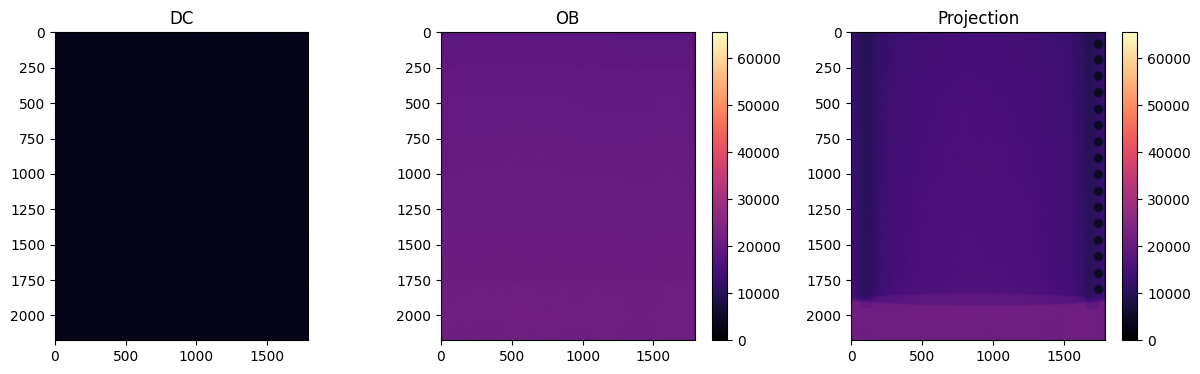

In [8]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax=ax.ravel()
ax[0].imshow(dc,cmap='magma')
ax[0].set_title('DC')
a1=ax[1].imshow(ob,cmap='magma')
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:],cmap='magma')
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

In [9]:
def normalizeData(img,ob,dc) :
    ob=ob-dc
    ob[ob<1]=1
    lcal=img.copy()
    for idx in np.arange(0, img.shape[0]):
        tmp=(img[idx,:,:]-dc)
        tmp[tmp<=0]=1
        lcal[idx,:,:]=(tmp/ob)
    lcal=-np.log(lcal)
    
    
    return lcal

(36, 2176, 1792)


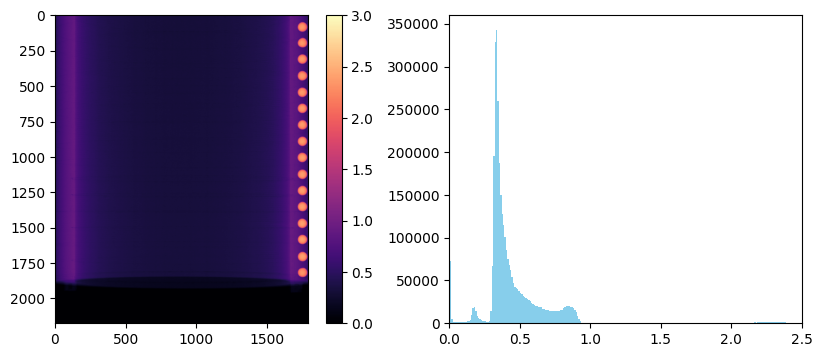

In [10]:
lcal=normalizeData(cal,ob,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,:,:] # [:, ::-1, :] reverses the order of elements along the second axis while leaving the other axes unchanged.
    
fig,ax=plt.subplots(1,2,figsize=(10,4))
im1 = ax[0].imshow(lcal[1],vmin=0,vmax=3,cmap='magma')
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[1].hist(lcal[1].ravel(),bins=1000,color='skyblue');
# Setting x-axis limits, for example from 0 to 100
ax[1].set_xlim(0, 2.5)

# ax[1].set_ylim(0, 500)

print(lcal.shape)


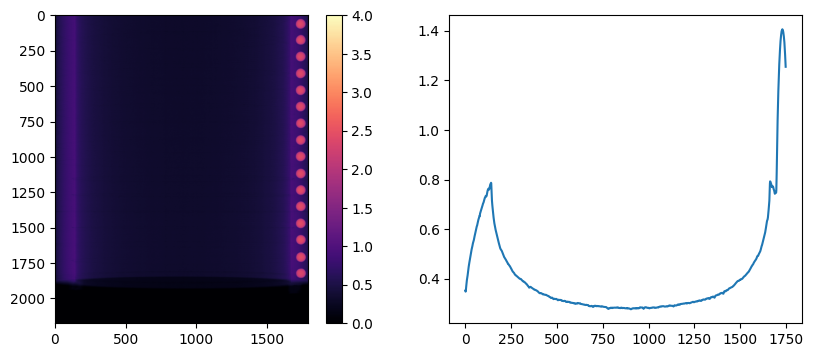

In [11]:
idx=2
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=4,cmap='magma')
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

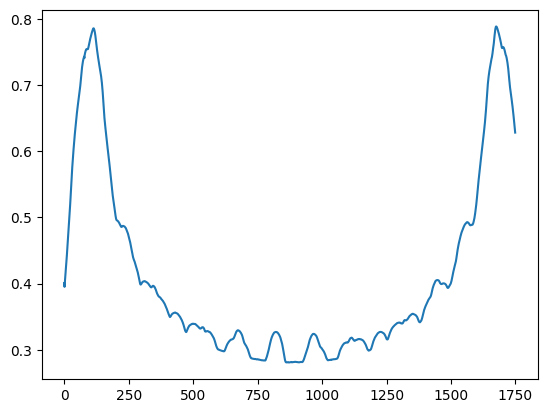

In [12]:
baseline = lcal.mean(axis=0).mean(axis=0)
baseline = baseline.reshape(1,baseline.shape[0])
plt.plot(baseline.ravel()[:1750])

In [13]:
def removeBaseline(img) :
    # img=img[:,:,0:1750]
    baseline = img.mean(axis=0).mean(axis=0)
    baseline = baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([img.shape[1],1]),baseline)
    res=img;
    print(b2.shape,res.shape)
    for idx in np.arange(0,img.shape[0]) :
        res[idx,:,:]=res[idx,:,:]-b2
    return res

lcal=removeBaseline(lcal)

(2176, 1792) (36, 2176, 1792)


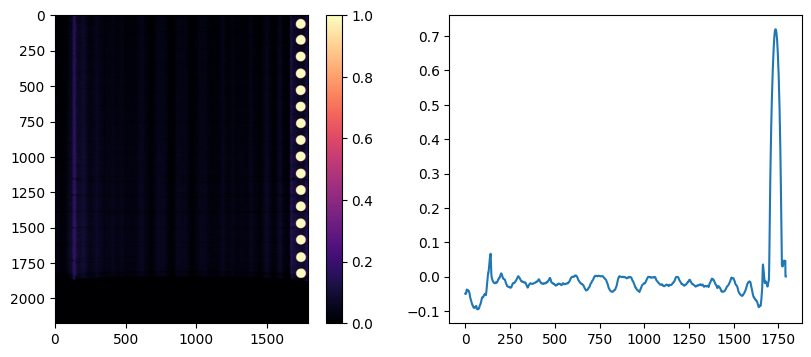

In [14]:
idx=2
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1,cmap='magma')
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0))

# Adjust thresholding value

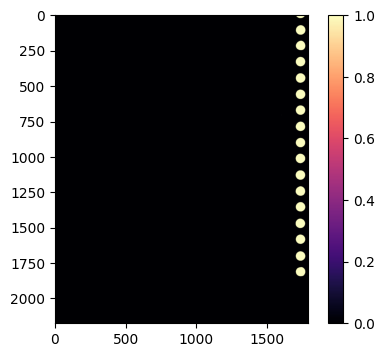

In [15]:
import cv2
import numpy as np

img = lcal
# Simple thresholding 
thresh_value =0.5


max_value = 1
thresh_type= cv2.THRESH_BINARY
thresh_img = []
for i in range(len(img)):
    thresh_type = cv2.THRESH_BINARY
    ret, thresh_img1 = cv2.threshold(img[i,:,:], thresh_value, max_value, thresh_type)
    thresh_img.append(thresh_img1)
#ret: The threshold value that was used to separate the foreground from the background. This value can be useful for further analysis or tuning of the thresholding operation.
thresh_img = np.array(thresh_img)


fig,ax=plt.subplots(figsize=[5,4])
im1 = ax.imshow(thresh_img[0,:,:],vmin=0,vmax=1,cmap='magma')
fig.colorbar(im1, ax=ax, shrink=1)


__Note:__ This operation can be made much more efficient when you work directly with numpy arrays instead of appending slices to a list.m

The watershed algorithm labels each segment with a unique integer value, which explains why the resulting segmented features are not binary and why the range of values can be from 0 to 32 (or higher, depending on the number of segments). Each unique integer represents a different segmented region.

If you want to visualize the segmented regions in a binary format, you can convert these regions into separate binary masks. Each unique label can be turned into a binary mask where the pixels belonging to that region are set to 1 and all other pixels are set to 0.

type: type of thresholding operation:
- cv2.THRESH_BINARY: The thresholding operation sets pixels that exceed the threshold value to maxval and all other pixels to 0.
- cv2.THRESH_BINARY_INV: The thresholding operation sets pixels that exceed the threshold value to 0 and all other pixels to maxval.
- cv2.THRESH_TRUNC: The thresholding operation sets pixels that exceed the threshold value to the threshold value and all other pixels are unchanged.
- cv2.THRESH_TOZERO: The thresholding operation sets pixels that exceed the threshold value to their original value and all other pixels to 0.
- cv2.THRESH_TOZERO_INV: The thresholding operation sets pixels that exceed the threshold value to 0 and all other pixels to their original value.

  0%|          | 0/36 [00:00<?, ?it/s]

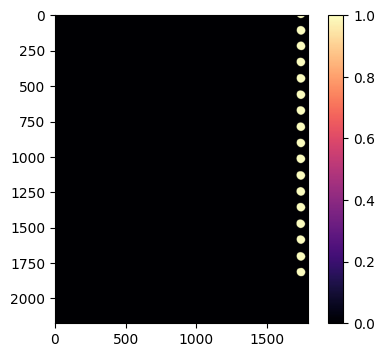

In [16]:
# Define the structuring element for erosion and dilation
kernel_size = 2
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

eroded_img= [] # Create a zero valued array to store the eroded images instead of working with a list
dilated_img= []
for i in tqdm(range(len(thresh_img))):
    # Perform erosion to remove small noise
    erosion_iterations = 6
    eroded_img1 = cv2.erode(thresh_img[i,:,:], kernel, iterations=erosion_iterations)
    eroded_img.append(eroded_img1)

    # Perform dilation to fill small gaps
    dilation_iterations = 1
    dilated_img1 = cv2.dilate(eroded_img1, kernel, iterations=dilation_iterations)
    dilated_img.append(dilated_img1)


eroded_img= np.array(eroded_img)
dilated_img= np.array(dilated_img)   

fig,ax=plt.subplots(figsize=(5,4))
im1 = ax.imshow(eroded_img[0,:,:],vmin=0,vmax=1,cmap='magma')
fig.colorbar(im1, ax=ax, shrink=1)


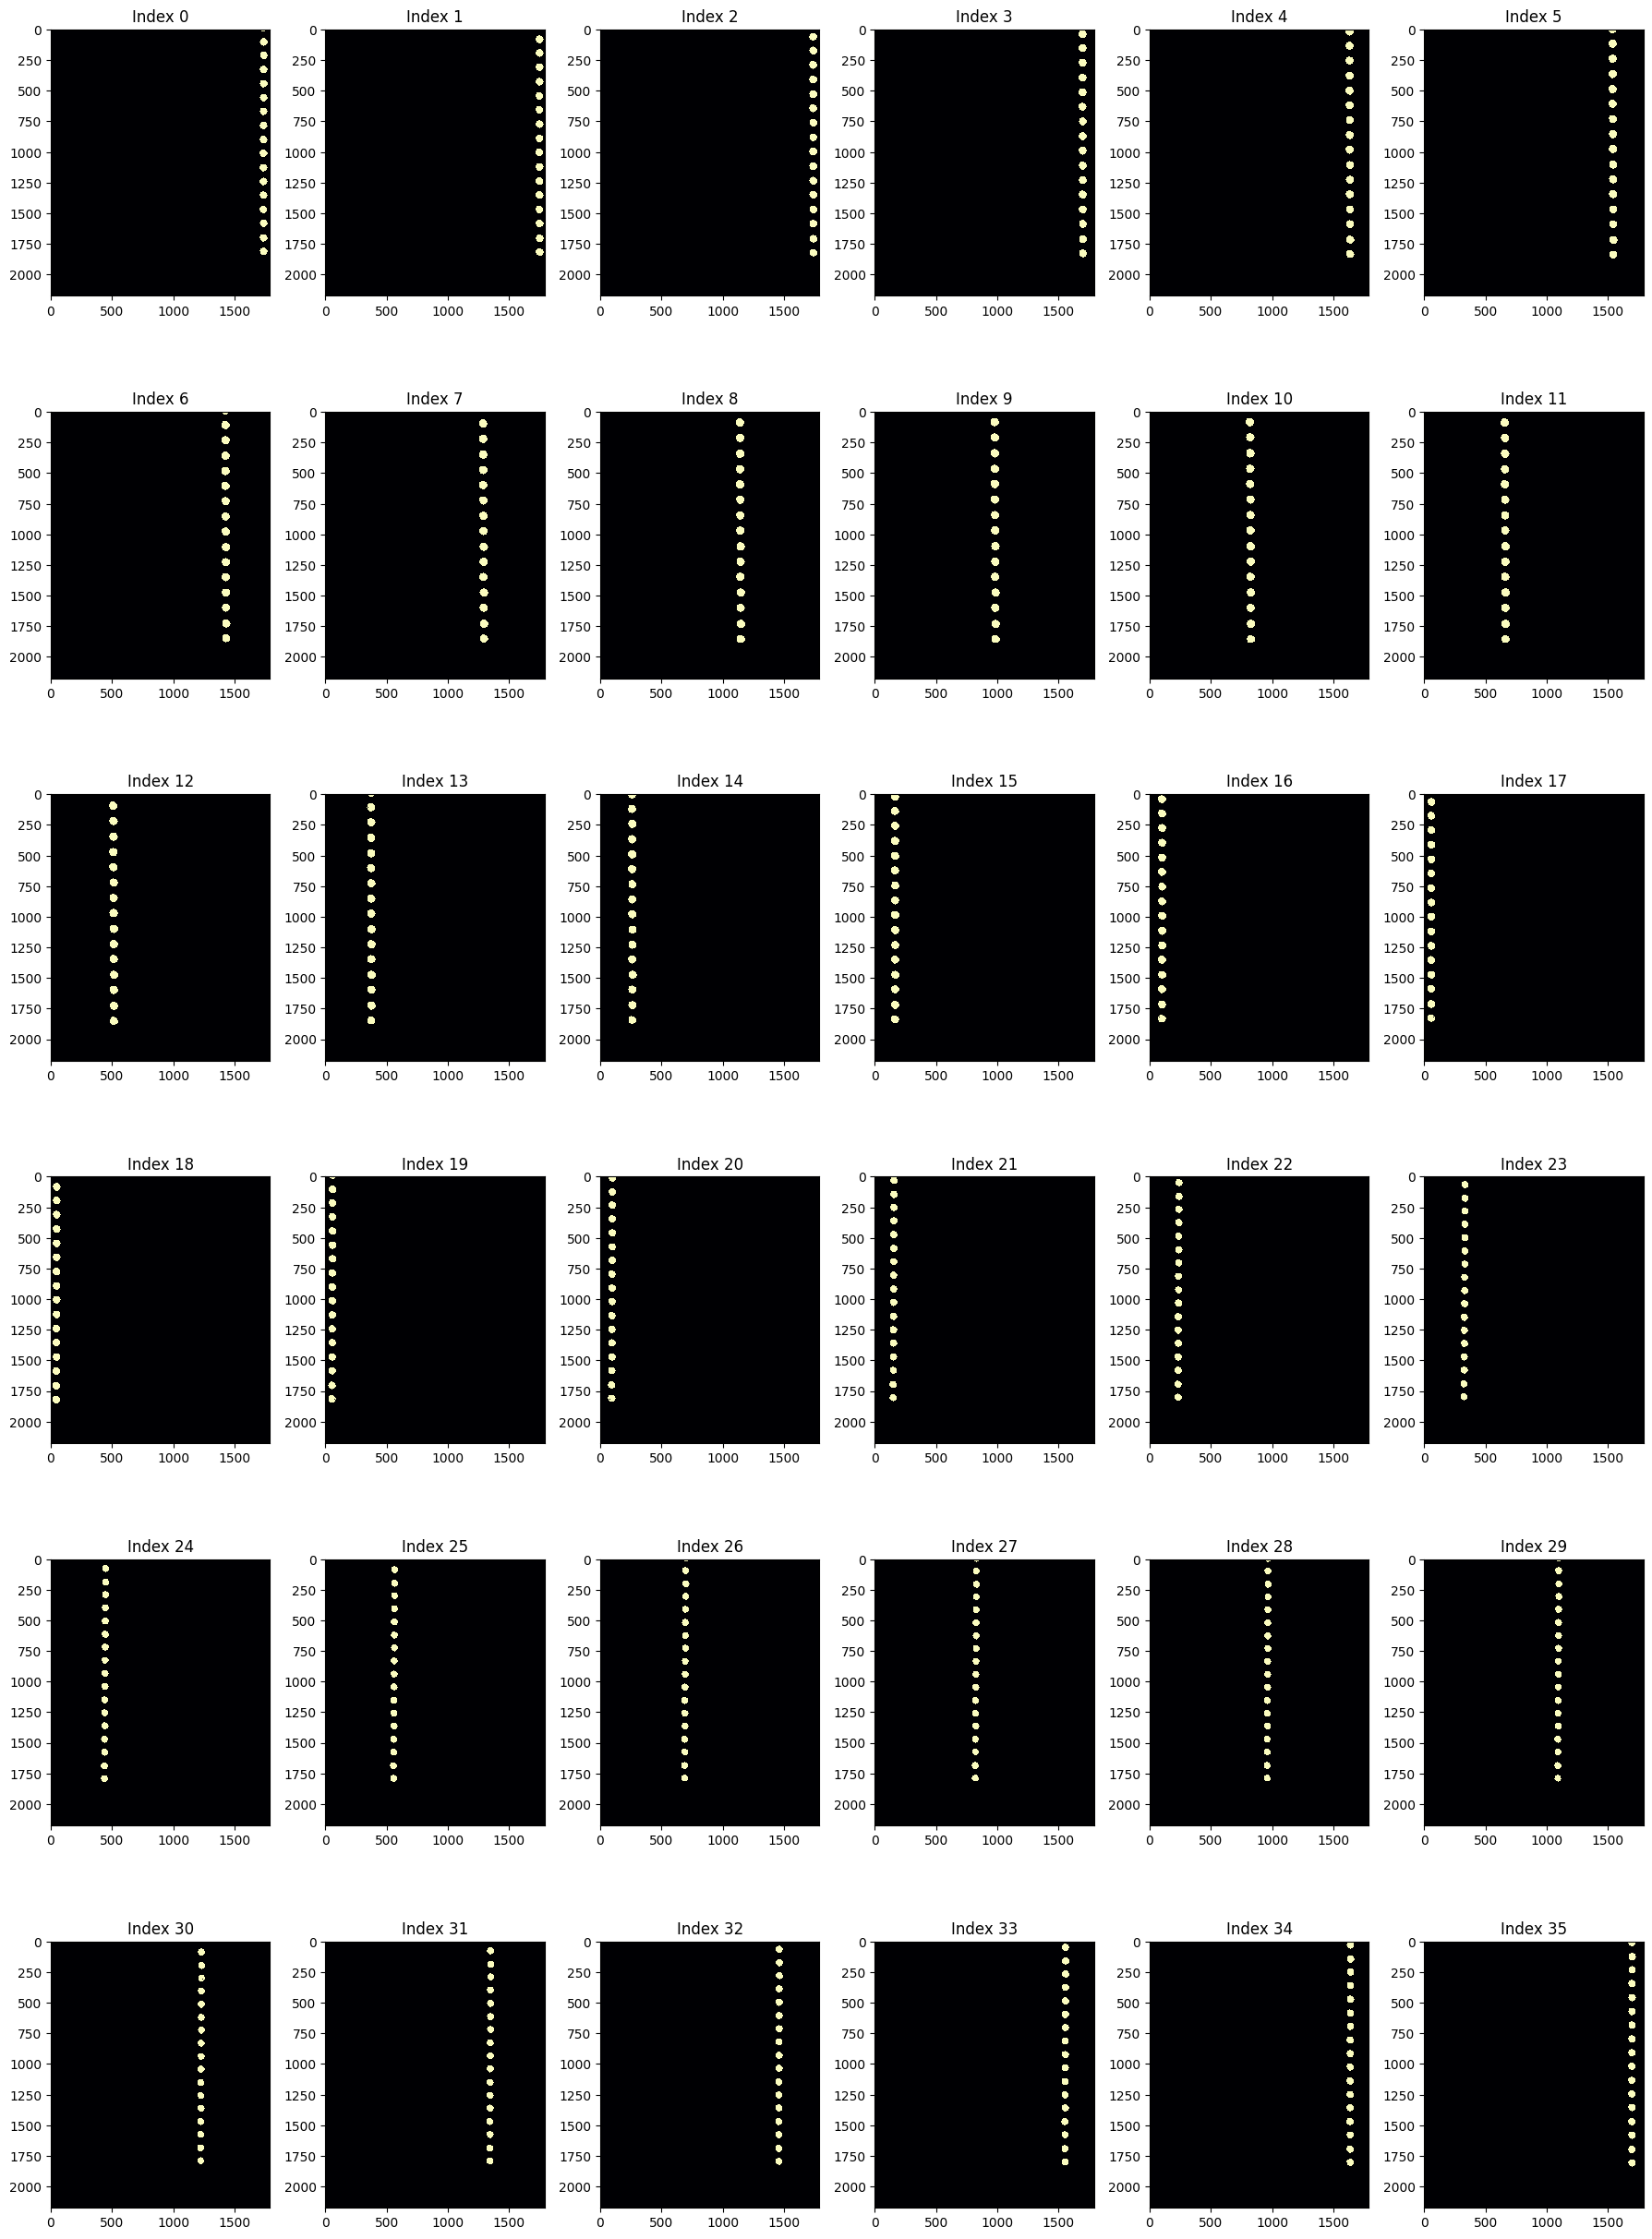

In [17]:

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 25))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(dilated_img[i, :, :], vmin=0, vmax=1,cmap='magma', interpolation='None')
#     ax.axhline(y=250, color='white', linestyle='--')  # Add a horizontal line at y=250
    ax.set_title(f'Index {i}')  # Set a title for each subplot
#     fig.colorbar(im, ax=ax, shrink=0.6)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [18]:
# Perform connected component labeling on the first image
ret, labels = cv2.connectedComponents(dilated_img[0,:,:].astype(np.uint8))
num_beads = ret - 1
bead_ids = np.arange(1, num_beads + 1)
print(num_beads)
print(bead_ids.shape)

17
(17,)


In [19]:
bead_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

Detected 17 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Bead positions: [[1815, 1735], [1705, 1734], [1586, 1734], [1474, 1733], [1357, 1734], [1246, 1734], [1132, 1733], [1015, 1733], [903, 1734], [789, 1734], [674, 1734], [562, 1734], [447, 1734], [331, 1734], [217, 1735], [108, 1735], [9, 1734]]
Bead intersections: [[1815 1735]
 [1705 1734]
 [1586 1734]
 [1474 1733]
 [1357 1734]
 [1246 1734]
 [1132 1733]
 [1015 1733]
 [ 903 1734]
 [ 789 1734]
 [ 674 1734]
 [ 562 1734]
 [ 447 1734]
 [ 331 1734]
 [ 217 1735]
 [ 108 1735]
 [   9 1734]]


<function matplotlib.pyplot.show(close=None, block=None)>

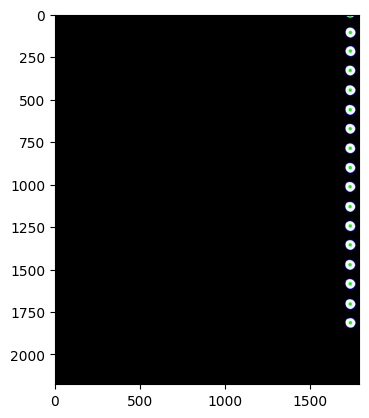

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Find the contours of the beads in the first image
contours, _ = cv2.findContours(dilated_img[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Compute the center of mass of each contour using its moments
bead_positions = []
for i, contour in enumerate(contours):
    moments = cv2.moments(contour)
    cx = int(moments['m10'] / moments['m00']+0.00001)
    cy = int(moments['m01'] / moments['m00']+0.00001)
    bead_positions.append([cy, cx])

# Fit a line to the bead positions using PCA
cov = np.cov(np.array(bead_positions).T)
eigenvalues, eigenvectors = np.linalg.eig(cov)
line_dir = eigenvectors[:, np.argmax(eigenvalues)]
mean_pos = np.mean(bead_positions, axis=0)
x1 = int(mean_pos[1] - 1000 * line_dir[1])
y1 = int(mean_pos[0] - 1000 * line_dir[0])
x2 = int(mean_pos[1] + 1000 * line_dir[1])
y2 = int(mean_pos[0] + 1000 * line_dir[0])

# Compute the intersection of each bead with the line
bead_intersections = []
for i, bead_pos in enumerate(bead_positions):
    # Compute the projection of the bead onto the line
    a = np.array([x1, y1])
    b = np.array([x2, y2])
    p = np.array(bead_pos)
    ap = p - a
    ab = b - a
    proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

    # Compute the distance from the projection to the bead
    dist = np.linalg.norm(p - proj)

    # If the distance is small enough, use the projection as the intersection point
    if dist < 10:
        bead_intersections.append(proj)
    else:
        # Otherwise, use the bead position as the intersection point
        bead_intersections.append(bead_pos)

# Convert the bead intersections to a NumPy array
bead_intersections = np.array(bead_intersections)

# Assign unique IDs to each bead
num_beads = len(bead_positions)
bead_ids = np.arange(1, num_beads + 1)

print(f"Detected {num_beads} beads with IDs {bead_ids}")
print(f"Bead positions: {bead_positions}")
print(f"Bead intersections: {bead_intersections}")

# Draw the contours and bead positions on the first image
contour_img = cv2.cvtColor(dilated_img[0], cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 0, 1), 2)
for i, bead_pos in enumerate(bead_positions):
    cv2.circle(contour_img, tuple(bead_pos[::-1]), 10, (0, 0, 1), -1)
    cv2.circle(contour_img, tuple(bead_intersections[i,::-1].astype(int)), 10, (0, 1, 0), -1)

    

# Show the result
plt.imshow(contour_img)
plt.show

In [21]:
bp = np.array(bead_positions)

In [22]:
bp.shape

(17, 2)

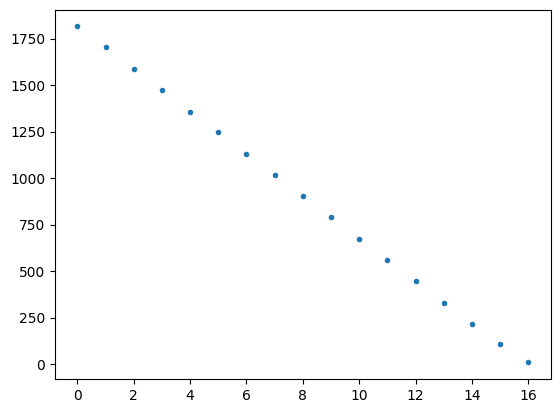

In [23]:
plt.plot(bp[:,0],'.')

the algorithm computes the projection of each bead position onto the line fitted to the beads using PCA. The distance between the projection and the actual bead position is then calculated. If this distance is smaller than a certain threshold, the algorithm assumes that the projection is a good estimate of the actual intersection point between the bead and the line. Therefore, it uses the projection as the intersection point in this case.

In other words, if the distance between the projection and the actual bead position is small enough, the algorithm assumes that the projection is very close to the actual intersection point and can be used as a substitute. This is because the intersection point should be very close to the line fitted to the beads, and the projection is the point on the line that is closest to the actual bead position. However, if the distance is too large, the algorithm assumes that the projection is not a good estimate of the actual intersection point and uses the actual bead position as the intersection point instead.

The sensitivity threshold in this context is used to determine whether a bead's position should be adjusted to its intersection point with the fitted line or if it should remain unchanged. Here's how it works:

Computing Bead Intersections with the Fitted Line:
For each bead position, the script computes its projection onto the fitted line.
It then calculates the distance between the bead position and its projection onto the line.
Threshold Comparison:
The script compares the distance between the bead position and its projection with the sensitivity threshold.
If the distance is less than the sensitivity threshold, it considers the projection as the intersection point.
If the distance is greater than or equal to the sensitivity threshold, it retains the original bead position as the intersection point.
Adjusting Bead Positions:
If the distance between the bead position and its projection is below the sensitivity threshold, the bead position is adjusted to the intersection point.
If the distance is above the sensitivity threshold, the original bead position is retained without adjustment.
Effect of Sensitivity:
A higher sensitivity threshold means that bead positions are adjusted only if they are very close to the fitted line.
A lower sensitivity threshold means that bead positions are adjusted even if they are slightly away from the fitted line.
Purpose:
The sensitivity threshold helps control the strictness of considering a bead to intersect the fitted line.
It allows for some flexibility in deciding when to adjust bead positions, based on how closely the beads are expected to align with the line.

Detected 17 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Bead positions: [[1815, 1735], [1705, 1734], [1586, 1734], [1474, 1733], [1357, 1734], [1246, 1734], [1132, 1733], [1015, 1733], [903, 1734], [789, 1734], [674, 1734], [562, 1734], [447, 1734], [331, 1734], [217, 1735], [108, 1735], [9, 1734]]
Bead intersections: [[1815, 1735], [1705, 1734], [1586, 1734], [1474, 1733], [1357, 1734], [1246, 1734], [1132, 1733], [1015, 1733], [903, 1734], [789, 1734], [674, 1734], [562, 1734], [447, 1734], [331, 1734], [217, 1735], [108, 1735], [9, 1734]]


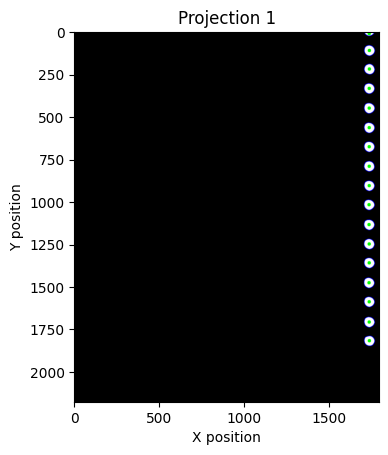

Detected 16 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Bead positions: [[1821, 1749], [1708, 1749], [1588, 1748], [1474, 1747], [1355, 1748], [1242, 1748], [1127, 1748], [1008, 1747], [894, 1748], [778, 1748], [661, 1748], [548, 1748], [431, 1748], [313, 1747], [198, 1748], [86, 1748]]
Bead intersections: [[1821, 1749], [1708, 1749], [1588, 1748], [1474, 1747], [1355, 1748], [1242, 1748], [1127, 1748], [1008, 1747], [894, 1748], [778, 1748], [661, 1748], [548, 1748], [431, 1748], [313, 1747], [198, 1748], [86, 1748]]
Detected 16 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Bead positions: [[1826, 1737], [1712, 1737], [1589, 1737], [1474, 1736], [1353, 1736], [1238, 1736], [1122, 1736], [1001, 1735], [885, 1736], [767, 1736], [648, 1735], [533, 1735], [414, 1735], [295, 1735], [177, 1736], [64, 1735]]
Bead intersections: [[1826, 1737], [1712, 1737], [1589, 1737], [1474, 1736], [1353, 1736], [1238, 1736], [1122, 1736], [1001, 1735], [885, 1736], 

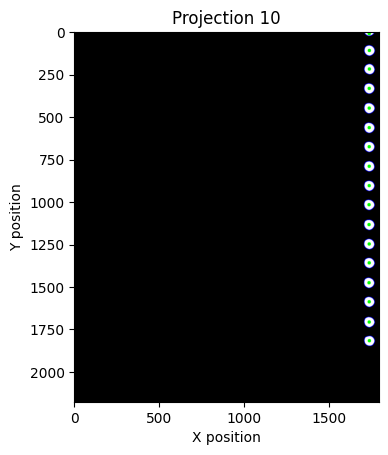

Detected 15 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Bead positions: [[1853, 824], [1729, 825], [1597, 822], [1473, 825], [1344, 821], [1220, 823], [1096, 823], [966, 821], [841, 820], [714, 820], [588, 818], [464, 819], [337, 819], [208, 819], [82, 817]]
Bead intersections: [[1853, 824], [1729, 825], [1597, 822], [1473, 825], [1344, 821], [1220, 823], [1096, 823], [966, 821], [841, 820], [714, 820], [588, 818], [464, 819], [337, 819], [208, 819], [82, 817]]
Detected 16 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Bead positions: [[1852, 664], [1728, 665], [1597, 663], [1473, 665], [1344, 661], [1221, 663], [1096, 663], [967, 661], [843, 661], [716, 661], [590, 659], [467, 660], [340, 660], [212, 660], [86, 658], [0, 658]]
Bead intersections: [[1852, 664], [1728, 665], [1597, 663], [1473, 665], [1344, 661], [1221, 663], [1096, 663], [967, 661], [843, 661], [716, 661], [590, 659], [467, 660], [340, 660], [212, 660], [86, 658], [0, 658]]
Detected 

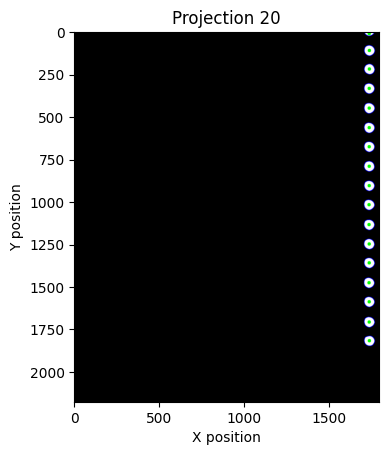

Detected 17 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Bead positions: [[1809, 92], [1700, 92], [1583, 93], [1472, 94], [1357, 95], [1247, 94], [1136, 95], [1020, 96], [910, 96], [797, 95], [684, 97], [574, 97], [461, 97], [346, 98], [235, 97], [127, 98], [18, 99]]
Bead intersections: [[1809, 92], [1700, 92], [1583, 93], [1472, 94], [1357, 95], [1247, 94], [1136, 95], [1020, 96], [910, 96], [797, 95], [684, 97], [574, 97], [461, 97], [346, 98], [235, 97], [127, 98], [18, 99]]
Detected 17 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Bead positions: [[1804, 152], [1697, 151], [1581, 153], [1472, 153], [1359, 154], [1250, 154], [1141, 154], [1027, 156], [918, 155], [806, 155], [695, 157], [587, 157], [475, 157], [362, 157], [252, 157], [146, 159], [31, 158]]
Bead intersections: [[1804, 152], [1697, 151], [1581, 153], [1472, 153], [1359, 154], [1250, 154], [1141, 154], [1027, 156], [918, 155], [806, 155], [695, 157], [587, 157], [475, 157], [

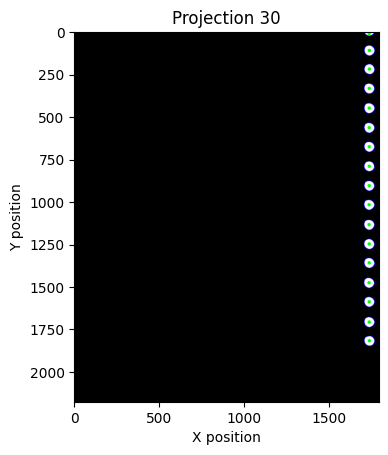

Detected 18 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Bead positions: [[1792, 1221], [1688, 1221], [1578, 1223], [1473, 1221], [1364, 1224], [1260, 1222], [1155, 1223], [1046, 1224], [941, 1225], [834, 1225], [727, 1227], [623, 1226], [516, 1226], [408, 1227], [302, 1228], [200, 1229], [91, 1227], [6, 1229]]
Bead intersections: [[1792, 1221], [1688, 1221], [1578, 1223], [1473, 1221], [1364, 1224], [1260, 1222], [1155, 1223], [1046, 1224], [941, 1225], [834, 1225], [727, 1227], [623, 1226], [516, 1226], [408, 1227], [302, 1228], [200, 1229], [91, 1227], [6, 1229]]
Detected 18 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Bead positions: [[1795, 1344], [1690, 1343], [1578, 1345], [1473, 1343], [1364, 1346], [1259, 1344], [1153, 1345], [1043, 1346], [937, 1347], [830, 1346], [722, 1348], [617, 1348], [509, 1348], [400, 1348], [294, 1350], [190, 1350], [81, 1348], [2, 1350]]
Bead intersections: [[1795, 1344], [1690, 1343], [1578, 1345],

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sensitivity threshold for detecting beads
sensitivity = 0.7

# Find the contours and intersections of the beads in each projection
bead_positions_all = []
bead_intersections_all = []
bead_ids_all = []
for i in range(dilated_img.shape[0]):
    # Find the contours of the beads in the current projection
    contours, _ = cv2.findContours(dilated_img[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the center of mass of each contour using its moments
    bead_positions = []
    for j, contour in enumerate(contours):
        moments = cv2.moments(contour)
        if moments['m00'] == 0:
            continue
        cx = int(moments['m10'] / moments['m00']+0.000001)
        cy = int(moments['m01'] / moments['m00']+0.000001)
        bead_positions.append([cy, cx])


    # Fit a line to the bead positions using PCA
    cov = np.cov(np.array(bead_positions).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    line_dir = eigenvectors[:, np.argmax(eigenvalues)]
    mean_pos = np.mean(bead_positions, axis=0)
    x1 = int(mean_pos[1] - 1000 * line_dir[1])
    y1 = int(mean_pos[0] - 1000 * line_dir[0])
    x2 = int(mean_pos[1] + 1000 * line_dir[1])
    y2 = int(mean_pos[0] + 1000 * line_dir[0])

    # Compute the intersection of each bead with the line
    bead_intersections = []
    bead_ids = []
    for j, bead_pos in enumerate(bead_positions):
        # Compute the projection of the bead onto the line
        a = np.array([x1, y1])
        b = np.array([x2, y2])
        p = np.array(bead_pos)
        ap = p - a
        ab = b - a
        proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

        # Compute the distance from the projection to the bead
        dist = np.linalg.norm(p - proj)

        # If the distance is small enough, use the projection as the intersection point
        if dist < sensitivity:
            bead_intersections.append(proj)
        else:
            # Otherwise, use the bead position as the intersection point
            bead_intersections.append(bead_pos)

        # Append the bead ID to the list
        bead_ids.append(j+1)

    bead_positions_all.append(bead_positions)
    bead_intersections_all.append(bead_intersections)
    bead_ids_all.append(bead_ids)
    
    # Assign unique IDs to each bead
    num_beads = len(bead_positions)
    bead_ids = np.arange(1, num_beads + 1)

    print(f"Detected {num_beads} beads with IDs {bead_ids}")
    print(f"Bead positions: {bead_positions}")
    print(f"Bead intersections: {bead_intersections}")

    # Show the result for some specific projections
    if i in [0, 9, 19, 29]:
        fig, ax = plt.subplots()
        ax.imshow(contour_img)
        ax.set_title(f"Projection {i+1}")
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_aspect('equal', 'box')
        plt.show()


In [25]:
# Find unique lengths of the sublists
unique_lengths = set(len(sublist) for sublist in bead_positions_all)

print(f"Unique lengths of sublists: {unique_lengths}")


Unique lengths of sublists: {16, 17, 18, 15}


In [26]:
# Convert to numpy arrays with integer type
bead_ids_all = [np.array(item, dtype=int) for item in bead_ids_all]

# Find the maximum length
max_len_ids = max(len(item) for item in bead_ids_all)

# Pad the arrays
bead_ids_all_padded = np.array([
    np.pad(item, (0, max_len_ids - len(item)), 'constant', constant_values=-1)  # Using -1 as the padding value for missing IDs
    for item in bead_ids_all
])

print("bead_ids_all_padded shape:", bead_ids_all_padded.shape)


bead_ids_all_padded shape: (36, 18)


In [27]:
# Ensure all items are numpy arrays of the same data type before padding
bead_positions_all = [np.array(item, dtype=float) if not isinstance(item, np.ndarray) else item.astype(float)
                      for item in bead_positions_all]

max_len = max(len(item) for item in bead_positions_all)

# Now, pad the arrays ensuring they all have the same length
bead_positions_all_padded = np.array([np.pad(item, ((0, max_len - len(item)), (0, 0)), 'constant', constant_values=np.nan)
                                      for item in bead_positions_all])
# Find the maximum dimensions in each direction
max_len_0 = max(item.shape[0] for item in bead_positions_all)  # Number of beads
max_len_1 = max(item.shape[1] for item in bead_positions_all)  # Dimensions per bead, e.g., (x, y)

# Pad the arrays to these maximum dimensions
bead_positions_all_padded = np.array([
    np.pad(item, ((0, max_len_0 - item.shape[0]), (0, max_len_1 - item.shape[1])), 'constant', constant_values=np.nan)
    for item in bead_positions_all
])
print("bead_positions_all_padded shape:", bead_positions_all_padded.shape)


bead_positions_all_padded shape: (36, 18, 2)


In [29]:
# Ensure all items are numpy arrays of the same data type before padding
bead_intersections_all = [np.array(item, dtype=float) if not isinstance(item, np.ndarray) else item.astype(float)
                          for item in bead_intersections_all]

# Find the maximum dimensions in each direction
max_len_intersections = max(len(item) for item in bead_intersections_all)
max_len_0_intersections = max(item.shape[0] for item in bead_intersections_all if item.ndim > 1)  # Number of intersections
max_len_1_intersections = 2  # Assuming intersections are 2D points (x, y)

# Pad the arrays to these maximum dimensions
bead_intersections_all_padded = np.array([
    np.pad(item, ((0, max_len_0_intersections - item.shape[0]), (0, max_len_1_intersections - item.shape[1])), 'constant', constant_values=np.nan)
    if item.ndim > 1 else np.pad(item, (0, max_len_intersections - len(item)), 'constant', constant_values=np.nan)
    for item in bead_intersections_all
])

print("bead_intersections_all_padded shape:", bead_intersections_all_padded.shape)


bead_intersections_all_padded shape: (36, 18, 2)


In [30]:
# # Convert to arrays
bead_positions_all = np.array(bead_positions_all_padded)
bead_intersections_all = np.array(bead_intersections_all_padded)
bead_ids_all = np.array(bead_ids_all_padded)



This code snippet implements optical flow tracking using the Lucas-Kanade method to track feature points (bead positions) across consecutive frames (projections) of an image sequence. Here's a breakdown of what each part does:

- Initialization of Feature Points:
The initial feature points are defined as the bead positions in the first projection (bead_positions_all[0]).
These feature points are converted to the appropriate format (dtype=np.float32) and reshaped for compatibility with the Lucas-Kanade method.
- Lucas-Kanade Parameters:
Parameters for the Lucas-Kanade optical flow algorithm are defined, including window size, maximum pyramid level, and termination criteria (lk_params).
- Optical Flow Calculation:
The script iterates over each subsequent projection (i) starting from the second frame.
For each frame, it converts the current and previous frames to CV_8U format.
The cv2.calcOpticalFlowPyrLK() function calculates the optical flow of the feature points from the previous frame to the current frame.
It returns the new positions (p1) of the tracked feature points in the current frame.
- Tracking Validation:
Unsuccessful tracked points (where optical flow couldn't be computed successfully) are removed.
The script detects new feature points in the current frame (bead_positions_all[i]) to compensate for any points lost during tracking.
- Trajectory Calculation:
The trajectories of the feature points up to the current frame are calculated and stored.
Each trajectory is represented as a sequence of (x, y) coordinates.
- Conversion to NumPy Arrays:
Finally, the trajectories are converted into a NumPy array (trajectories) for further analysis or visualization.

The point IDs are not explicitly used for tracking. Instead, the script relies on the spatial correspondence of feature points (bead positions) between consecutive frames to perform optical flow tracking. Here's how it works:

Initialization of Feature Points:
Initially, feature points are defined as the bead positions in the first projection (bead_positions_all[0]).
These feature points serve as the initial set of points to track.
Optical Flow Calculation:
For each subsequent frame (projection), the script calculates the optical flow of feature points from the previous frame to the current frame.
The cv2.calcOpticalFlowPyrLK() function computes the new positions of the tracked feature points (p1) in the current frame based on their positions in the previous frame.
Tracking Validation and Adjustment:
The script removes any feature points that were not successfully tracked. This is done by examining the status returned by the optical flow calculation.
New feature points are detected in the current frame (bead_positions_all[i]) to compensate for any points lost during tracking.
Trajectory Calculation:
The trajectories of the feature points up to the current frame are calculated and stored.
Each trajectory represents the path traced by a feature point over time.

breaking down the parameters defined for the Lucas-Kanade optical flow method:

- winSize:
This parameter specifies the size of the window used for the optical flow calculation.
It determines the region around each feature point that is considered for tracking.
In this case, the window size is set to (15, 15), meaning a window of size 15x15 pixels will be used.
- maxLevel:
This parameter defines the maximum pyramid level for the Lucas-Kanade algorithm.
The Lucas-Kanade method often uses an image pyramid, where each level represents a different scale of the image.
Setting maxLevel to 2 means that the optical flow algorithm will consider a maximum of two pyramid levels for tracking.
The use of multiple pyramid levels can improve tracking accuracy by allowing the algorithm to handle large motion more effectively.
- criteria:
This parameter specifies the termination criteria for the iterative process used by the Lucas-Kanade algorithm.
It defines when the iterative process should stop based on certain conditions.
cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT indicates that the termination criterion is a combination of two conditions: either a specified number of iterations (cv2.TERM_CRITERIA_COUNT) or a specified accuracy (cv2.TERM_CRITERIA_EPS).
In this case, the specified number of iterations is 10, and the specified accuracy is 0.03.
cv2.TERM_CRITERIA_COUNT: This condition specifies that the iterative process should stop after a certain number of iterations (in this case, 10).
cv2.TERM_CRITERIA_EPS: This condition specifies that the iterative process should stop when the change in the tracked feature points falls below a certain threshold (in this case, 0.03).
This termination criteria ensures that the iterative process stops either after a maximum number of iterations or when the change in the tracked points becomes small enough, indicating convergence.
Overall, these parameters control the behavior of the Lucas-Kanade optical flow algorithm, including the size of the tracking window, the number of pyramid levels used, and the criteria for terminating the iterative process. Adjusting these parameters can affect the accuracy and speed of the optical flow tracking.

The initial feature points are defined with their IDs in the first projection. The IDs are updated in each frame, and new feature points are detected with their IDs in the current frame. Then the trajectories of the feature points are calculated up to the current frame with their IDs stored in the trajectories dictionary.

There are several ways to improve the tracking:

Increase the size of the search window: If the beads move quickly or cover a large distance between frames, a small search window may not be able to capture their motion accurately. Increasing the size of the search window can help improve tracking performance.

Use multiple frames for tracking: Instead of tracking beads frame-by-frame, using multiple frames can help improve tracking accuracy. This is because using multiple frames can help to smooth out errors and reduce noise in the tracking data.

Use a better feature descriptor: The Lucas-Kanade algorithm relies on tracking feature points based on their intensity values. However, if the intensity values of the beads are not distinct enough, it may be difficult to track them accurately. Using a better feature descriptor, such as a SIFT or SURF feature descriptor, can help to improve tracking accuracy.

Use a different tracking algorithm: There are many different tracking algorithms available, and some may perform better than the Lucas-Kanade algorithm in certain situations. For example, the Kanade-Lucas-Tomasi (KLT) algorithm is a variant of the Lucas-Kanade algorithm that can handle larger displacements and changes in scale.

Improve the bead detection: Accurate tracking depends on accurate detection of the beads in each frame. Improving the bead detection algorithm, for example by using a more robust thresholding method or by incorporating prior knowledge about the shape and size of the beads, can help to improve tracking accuracy.

In [31]:
dilated_img = dilated_img.astype(np.uint8)

# Define the initial feature points as the bead positions in the first projection, along with their IDs
feature_points = np.hstack((bead_positions_all[0], np.array(bead_ids_all[0]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)

# Define the Lucas-Kanade parameters
lk_params = dict(winSize=(20, 20),
                 maxLevel=5,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.03))

# Loop over each subsequent projection and track the feature points
trajectories = {}
for i in range(1, dilated_img.shape[0]):
    # Calculate the optical flow of the feature points from the previous frame to the current frame
    p1, st, err = cv2.calcOpticalFlowPyrLK(dilated_img[i-1], dilated_img[i], feature_points[:, :, :2], None, **lk_params)

    # Remove any feature points that were not tracked successfully
    st = st.reshape(-1)
    feature_points = feature_points[st == 1]
    p1 = p1[st == 1]

    # Update the IDs of the feature points
    if feature_points.size > 0:
        feature_points[:, :, 2] = feature_points[:, :, 2] * st.reshape(-1, 1)

    # Detect new feature points in the current frame
    new_features = np.hstack((bead_positions_all[i], np.array(bead_ids_all[i]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)
    feature_points = np.vstack((feature_points, new_features))

    # Calculate the trajectories of the feature points up to the current frame
    for j in range(feature_points.shape[0]):
        x, y, ID = feature_points[j, 0]
        if ID not in trajectories:
            trajectories[ID] = []
        trajectories[ID].append([y, x])

# Convert the trajectories to NumPy arrays
for ID in trajectories:
    trajectories[ID] = np.array(trajectories[ID])


# Fit ellipses to each bead trajectory up to the current frame
for ID in trajectories:
    if len(trajectories[ID]) > 5: # Only fit ellipse if at least 6 points have been tracked
        # Convert the trajectory to a NumPy array
        trajectory = np.array(trajectories[ID])

        # Fit an ellipse to the trajectory using the method of moments
        ellipse = cv2.fitEllipse(trajectory)

        # Add the ellipse parameters to the trajectory dictionary
        trajectories[ID] = (trajectory, ellipse)
    else:
        # If there are not enough points, add None to the trajectory dictionary
        trajectories[ID] = (trajectory, None)


The Lucas-Kanade method is a classical optical flow method for tracking the motion of objects in a sequence of images or frames. It was proposed by Bruce D. Lucas and Takeo Kanade in their seminal 1981 paper, "An Iterative Image Registration Technique with an Application to Stereo Vision". The Lucas-Kanade method estimates the apparent motion of image features between two consecutive frames by solving a set of linear equations, which model the spatial and temporal intensity variations of the image features. The method assumes that the motion of the features is small and approximately constant within a local image region, and that the image brightness is constant over time. The Lucas-Kanade method is widely used for object tracking, image stabilization, and visual servoing in computer vision applications.
The essence of optical flow is to analyze the motion of objects in a video sequence by calculating the displacement of pixels between consecutive frames. It is a method used in computer vision to track the movement of objects in a video and estimate their speed and direction. Optical flow algorithms analyze the changes in intensity values of pixels between frames and use these changes to calculate the direction and speed of motion. Optical flow is a powerful tool used in many applications, such as motion detection, object tracking, video stabilization, and 3D reconstruction.

Script 2 initializes feature points with a subset of bead positions and IDs from the first projection, specifically the minimum number of beads present in all projections.

Script 2 includes a step to remove extra beads from each projection, ensuring that only the same number of beads are considered in all projections. Script 1 does not have this step.

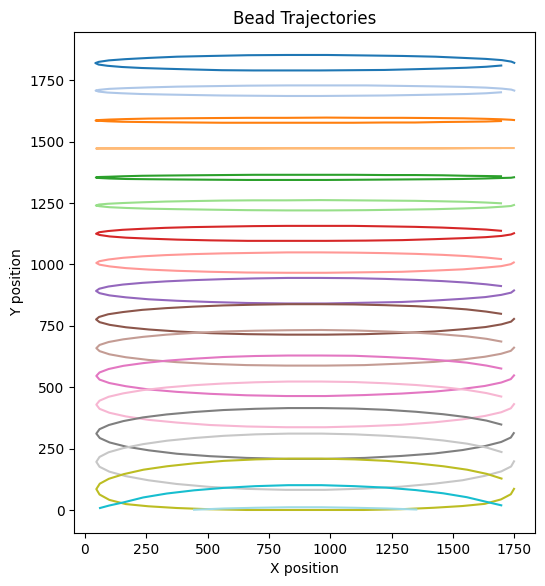

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
fig, ax = plt.subplots(figsize=(15,6.5))

# Create a colormap
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(trajectories)))

# Loop through the trajectories and plot each one with a unique color from the colormap
for index, (ID, data) in enumerate(trajectories.items()):
    if data[1] is not None:
        x, y = data[0][:, 0], data[0][:, 1]
        ax.plot(x, y, color=colors[index])#, label=f"Bead {ID}")

# Set aspects and labels
ax.set_aspect('equal', 'box')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Bead Trajectories')
# Optionally, you can enable the legend if you want to identify the beads by color
# plt.legend(title="Bead ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [33]:
# Convert the remaining bead positions to NumPy arrays
bead_positions_all = [np.array(bead_positions) for bead_positions in bead_positions_all]

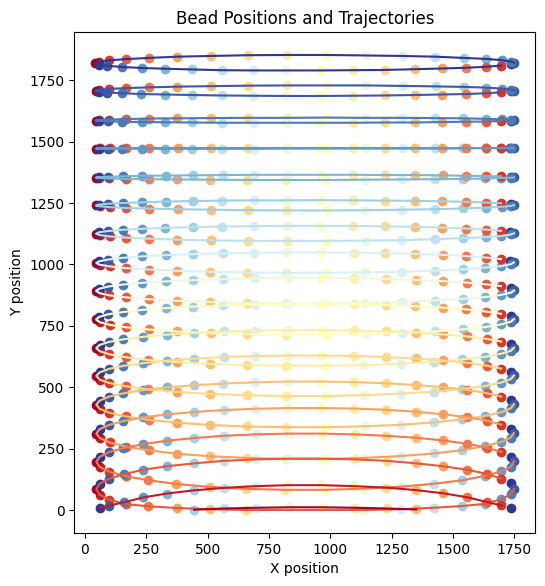

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
fig, ax = plt.subplots(figsize=(15,6.5))

# Create a colormap
cmap = plt.get_cmap('RdYlBu_r')
colors = cmap(np.linspace(0, 1, len(trajectories)))

# Plot bead positions with colors from the plasma color map
for i in range(dilated_img.shape[0]):
    if len(bead_positions_all[i]) > 0:
        x, y = bead_positions_all[i][:, 1], bead_positions_all[i][:, 0]
        ax.scatter(x, y, color=colors[i % len(colors)])

# Plot trajectories with matching colors
for index, (ID, data) in enumerate(trajectories.items()):
    if data[1] is not None:
        x, y = data[0][:, 0], data[0][:, 1]
        ax.plot(x, y, color=colors[index % len(colors)])#, label=f"Bead {ID}")

# Set aspects and labels
ax.set_aspect('equal', 'box')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Bead Positions and Trajectories')
# Optionally, enable the legend to identify the beads by color
# plt.legend(title="Bead ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Overall, this script is useful for visually verifying the accuracy of trajectory tracking and ellipse fitting processes in an image analysis context, displaying how well the ellipses fit the trajectories of moving objects or features.








1.0
((892.870361328125, 1821.0272216796875), (63.264686584472656, 1704.9205322265625), 90.048095703125)
Ellipse(xy=(892.870361328125, 1821.0272216796875), width=1704.9205322265625, height=63.264686584472656, angle=90.048095703125)
2.0
((904.3630981445312, 1707.7493896484375), (42.84397506713867, 1708.3631591796875), 90.05025482177734)
Ellipse(xy=(904.3630981445312, 1707.7493896484375), width=1708.3631591796875, height=42.84397506713867, angle=90.05025482177734)
3.0
((899.0089721679688, 1587.1580810546875), (20.898672103881836, 1712.12158203125), 90.04832458496094)
Ellipse(xy=(899.0089721679688, 1587.1580810546875), width=1712.12158203125, height=20.898672103881836, angle=90.04832458496094)
4.0
((836.2742309570312, 1473.0484619140625), (1.6431798934936523, 1714.037109375), 90.05136108398438)
Ellipse(xy=(836.2742309570312, 1473.0484619140625), width=1714.037109375, height=1.6431798934936523, angle=90.05136108398438)
5.0
((889.9110717773438, 1354.56298828125), (21.019672393798828, 1698.89

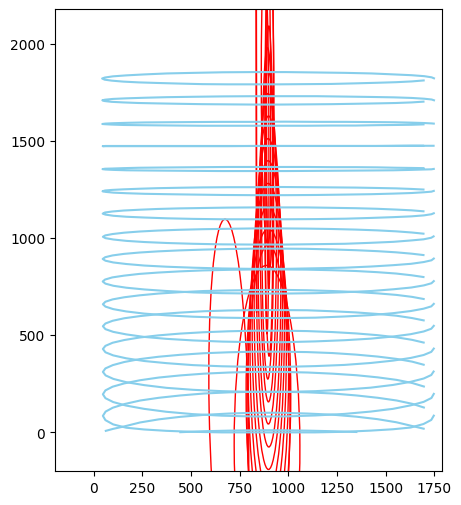

In [35]:
fig, ax = plt.subplots(figsize=(5,6))

ax.set_xlim(-200, 1792)
ax.set_ylim(-200, 2176)
for ID in trajectories:
    print(ID)
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        trajectory = trajectories[ID][0]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'skyblue')
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        ellipse    = trajectories[ID][1]
        print(ellipse)
        if ellipse[1][0]<ellipse[1][1] :
            width = ellipse[1][1]
            height = ellipse[1][0]
        else :
            width = ellipse[1][0]
            height = ellipse[1][1]  

        ellipse_patch = Ellipse(xy=ellipse[0], width=width, height=height, angle=ellipse[2], edgecolor='red', facecolor='none')
        print(ellipse_patch)
        ax.add_patch(ellipse_patch)
#plt.axis('equal')
#plt.show()


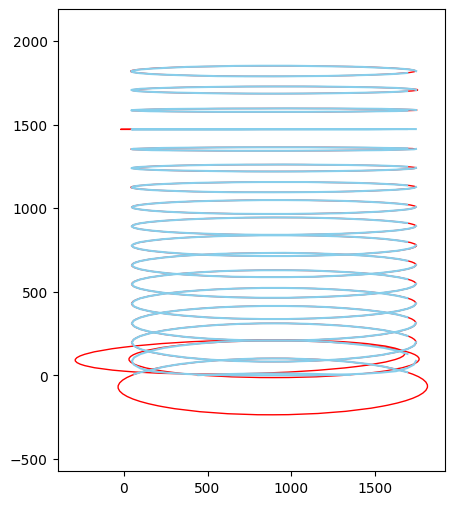

In [36]:
fig, ax = plt.subplots(figsize=(5,6))
for ID in trajectories:
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        trajectory = trajectories[ID][0]
        ellipse    = trajectories[ID][1]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'skyblue')
        ellipse_patch = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2], edgecolor='red', facecolor='none')
        ax.add_patch(ellipse_patch)
plt.axis('equal')
plt.show()

## removes ellipses with outlier major axis and orientation values:

In [37]:
len(trajectories)

19

In [38]:
# Calculate the major axis lengths of the ellipses
major_axis_lengths = [ellipse[1][1] for ID, (trajectory, ellipse) in trajectories.items() if ellipse is not None]

# Calculate the median major axis length
median_major_axis_length = np.median(major_axis_lengths)

# Define a threshold for major axis length as 2 times the median
major_axis_length_threshold = 1.6 * median_major_axis_length

# Remove outlier ellipses with major axis length greater than the threshold
for ID, (trajectory, ellipse) in list(trajectories.items()):
    if ellipse is not None and ellipse[1][1] > major_axis_length_threshold:
        trajectories.pop(ID)

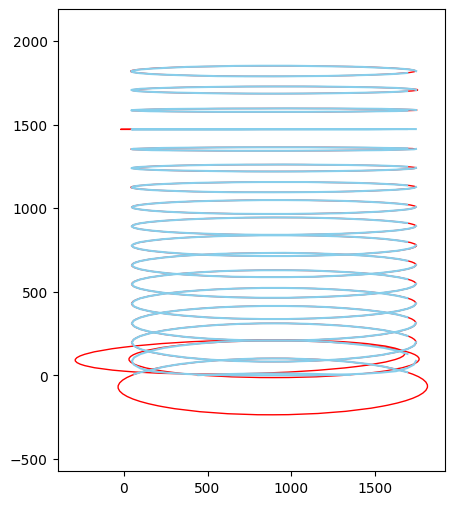

In [39]:
# repeated code from above, make a function instead
# something is broken here and above
fig, ax = plt.subplots(1,figsize=(5,6))

for ID in trajectories:
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        trajectory = trajectories[ID][0]
        ellipse = trajectories[ID][1]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'skyblue')
        ellipse_patch = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2], edgecolor='red', facecolor='none')
        plt.gca().add_patch(ellipse_patch)
plt.axis('equal')
plt.show()


This block of code extracts the x and y coordinates of the trajectories of the feature points that have successfully tracked and for which an ellipse has been fitted. Here's a step-by-step explanation:

- Initialization:
Two empty lists, trajectories_x and trajectories_y, are initialized to store the x and y coordinates of the trajectories, respectively.
- Iteration Over Trajectories:
The code iterates over each trajectory in the trajectories dictionary.
For each trajectory, it checks if an ellipse has been fitted (trajectories[ID][1] is not None). If an ellipse has been fitted, it proceeds; otherwise, it skips the trajectory.
- Extraction of Coordinates:
For each trajectory with a fitted ellipse, the x and y coordinates are extracted from the trajectory array (trajectories[ID][0]) using NumPy's ravel() function.
The tolist() method converts the NumPy array to a list format.
The extracted x coordinates are appended to the trajectories_x list, and the y coordinates are appended to the trajectories_y list.
- Conversion to NumPy Arrays:
Finally, the lists of x and y coordinates (trajectories_x and trajectories_y) are converted to NumPy arrays using np.array().

In [40]:

trajectories_x = []
trajectories_y = []

for ID in trajectories:
    if trajectories[ID][1] is not None:
        trajectories_x.append(np.ravel(trajectories[ID][0][:, 0]).tolist())
        trajectories_y.append(np.ravel(trajectories[ID][0][:, 1]).tolist())



In [41]:
# Determine the maximum trajectory length
max_trajectory_length = max(len(x) for x in trajectories_x)

# Pad trajectories so they all have the same length
trajectories_x = np.array([np.pad(x, (0, max_trajectory_length - len(x)), 'constant', constant_values=np.nan)
                                  for x in trajectories_x])
trajectories_y = np.array([np.pad(y, (0, max_trajectory_length - len(y)), 'constant', constant_values=np.nan)
                                  for y in trajectories_y])

print("Padded trajectories_x shape:", trajectories_x.shape)
print("Padded trajectories_y shape:", trajectories_y.shape)


Padded trajectories_x shape: (19, 47)
Padded trajectories_y shape: (19, 47)


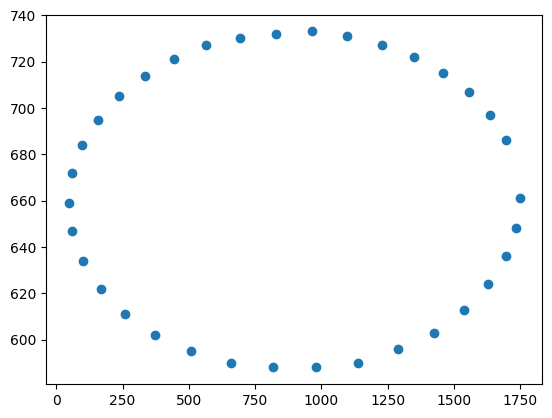

In [42]:
plt.scatter(trajectories_x[10],trajectories_y[10])

In [43]:
np.array(bead_ids_all[0]).reshape(-1, 1).shape

(18, 1)

In [44]:
np.array(bead_positions_all[0]).shape

(18, 2)

In [46]:
# fitting an ellipse 
# based on Fitzgibbon, Pilu, & Fisher (1996) and Halir & Flusser (1998)
def fit(x,y):
    D1 = np.vstack([x**2,x*y,y**2]).T
    D2 = np.vstack([x,y,np.ones_like(x)]).T
    S1,S2,S3 = D1.T @ D1, D1.T @ D2, D2.T @ D2
    C1 = np.array([[0,0,2],[0,-1,0],[2,0,0]])
    M = np.linalg.inv(C1) @ (S1 - S2 @ np.linalg.inv(S3) @ S2.T)
    vec = np.linalg.eig(M)[1]
    cond = 4*(vec[0]*vec[2]) - vec[1]**2
    a1 = vec[:,np.nonzero(cond > 0)[0]]
    return np.vstack([a1,np.linalg.inv(-S3) @ S2.T @ a1]).flatten()

In [47]:
# estimating the errors using chi-squared
from uncertainties import ufloat

def errors(x,y,coeffs):
    z = np.vstack((x**2,x*y,y**2,x,y,np.ones_like(x)))
    numerator = np.sum(((coeffs.reshape(1,6) @ z)-1)**2)
    denominator = (len(x)-6)*np.sum(z**2,axis=1)
    unc = np.sqrt(numerator/denominator)
    return tuple(ufloat(i,j) for i,j in zip(coeffs,unc))

In [ ]:
# def errors(x,y,coeffs):
#     if coeffs.ndim != 1:
#         raise ValueError("Coefficients must be a 1D array")
#     z = np.vstack((x**2,x*y,y**2,x,y,np.ones_like(x))).T
#     numerator = np.sum(((coeffs.reshape(-1, 1) @ z.T)-1)**2)

#     denominator = (len(x)-6)*np.sum(z**2,axis=1)
#     unc = np.sqrt(numerator/denominator)
#     return tuple(ufloat(i,j) for i,j in zip(coeffs,unc))


In [48]:
# converting the coefficients to ellipse parameters
import uncertainties
from uncertainties import umath
def convert(coeffs):
    a,b,c,d,e,f = coeffs
    b /= 2
    d /= 2
    e /= 2
    x0 = (c*d - b*e) / (b**2 - a*c)
    y0 = (a*e - b*d) / (b**2 - a*c)
    center = (x0, y0)
    numerator = 2 * (a*e**2 + c*d**2 + f*b**2 - 2*b*d*e - a*c*f)
    denominator1 = (b*b-a*c)*((c-a)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*((a-c)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    major = umath.sqrt(numerator/denominator1) if numerator/denominator1 > 0 else 0
    minor = umath.sqrt(numerator/denominator2) if numerator/denominator2 > 0 else 0
    phi = .5*umath.atan((2*b)/(a-c))
    major, minor, phi = (major, minor, phi) if major > minor else (minor, major, np.pi/2+phi)
    return center, major, minor, phi

In [49]:
# generating fit ellipse line
def line(coeffs,n=100):
    t = np.linspace(0,2*np.pi,n)
    center,major,minor,phi = convert(coeffs)
    x = major*np.cos(t)*np.cos(phi) - minor*np.sin(t)*np.sin(phi) + center[0]
    y = major*np.cos(t)*np.sin(phi) + minor*np.sin(t)*np.cos(phi) + center[1]
    return x,y

# alternative using matplotlib artists
def artist(coeffs,*args,**kwargs):
    center,major,minor,phi = convert(coeffs)
    return Ellipse(xy=(center[0],center[1]),width=2*major,height=2*minor,
                     angle=np.rad2deg(phi),*args,**kwargs)

In [50]:
# obtaining the confidence interval/area for ellipse fit
def confidence_area(x,y,coeffs,f=1): # f here is the multiple of sigma
    c = coeffs
    res = c[0]*x**2 + c[1]*x*y + c[2]*y**2 + c[3]*x + c[4]*y + c[5]
    sigma = np.std(res)
#     print('Sigma = ', sigma)
    c_up = np.array([c[0],c[1],c[2],c[3],c[4],c[5] + f*sigma])
    c_do = np.array([c[0],c[1],c[2],c[3],c[4],c[5] - f*sigma])
   
    if convert(c_do) > convert(c_up):
        c_do, c_up = c_up,c_do
    return c_up,c_do

In [51]:
def fit(x, y):
    # Convert x and y to float type if they are not already
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones_like(x)]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    C1 = np.array([[0, 0, 2], [0, -1, 0], [2, 0, 0]], dtype=float)

    # Attempt to invert S3 with safe handling for singular matrices
    try:
        S3_inv = np.linalg.inv(S3)
    except np.linalg.LinAlgError:
        print("Warning: S3 is singular, using pseudo-inverse.")
        S3_inv = np.linalg.pinv(S3)

    M = np.linalg.inv(C1) @ (S1 - S2 @ S3_inv @ S2.T)

    # Eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(M)
    cond = 4 * eig_vecs[0, :] * eig_vecs[2, :] - eig_vecs[1, :]**2
    valid_idx = np.where(cond > 0)[0]

    if valid_idx.size == 0:
        print("No valid ellipse found.")
        return None

    a1 = eig_vecs[:, valid_idx]
    return np.vstack([a1, np.linalg.solve(-S3, S2.T @ a1)]).flatten()



In [52]:
def fit(x, y):
    # Convert x and y to float type if they are not already
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones_like(x)]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    C1 = np.array([[0, 0, 2], [0, -1, 0], [2, 0, 0]], dtype=float)

    # Attempt to invert S3 with safe handling for singular matrices
    try:
        S3_inv = np.linalg.inv(S3)
    except np.linalg.LinAlgError:
        print("Warning: S3 is singular, using pseudo-inverse.")
        S3_inv = np.linalg.pinv(S3)

    M = np.linalg.inv(C1) @ (S1 - S2 @ S3_inv @ S2.T)

    # Eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(M)
    cond = 4 * eig_vecs[0, :] * eig_vecs[2, :] - eig_vecs[1, :]**2
    valid_idx = np.where(cond > 0)[0]

    if valid_idx.size == 0:
        print("No valid ellipse found.")
        return None

    a1 = eig_vecs[:, valid_idx]
    return np.vstack([a1, np.linalg.solve(-S3, S2.T @ a1)]).flatten()


In [53]:
def errors(x, y, coeffs):
    z = np.vstack((x**2, x*y, y**2, x, y, np.ones_like(x)))
    if coeffs.size == 12:
        coeffs = coeffs.reshape(2, 6)
    elif coeffs.size == 6:
        coeffs = coeffs.reshape(1, 6)
    numerator = np.sum(((coeffs @ z) - 1)**2)
    denominator = (len(x) - 6) * np.sum(z**2, axis=1)
    unc = np.sqrt(numerator / denominator)
    return tuple(ufloat(i, j) for i, j in zip(coeffs.flatten(), unc))


In [54]:
import numpy as np

def preprocess_data(x, y):
    """Preprocess the data by removing or imputing NaNs and Infs."""
    mask = np.isfinite(x) & np.isfinite(y)
    return x[mask], y[mask]
N = len(trajectories)
# Assuming trajectories_x and trajectories_y are lists of arrays
for iii, (x, y) in enumerate(zip(trajectories_x, trajectories_y)):
    print(f'Processing ID = {iii}')

    # Preprocess the data to remove NaNs and Infs
    x, y = preprocess_data(np.array(x), np.array(y))

    # Check if there's enough data left to perform fitting
    if len(x) < 3 or len(y) < 3:
        print(f"Not enough valid data points to fit an ellipse for ID = {iii}")
        continue

    for ell_ii in range(N):
        try:
            # Perform the fitting and other calculations here
            params1 = fit(x, y)
            params1 = errors(x, y, params1)
            center, a, b, phi = convert(params1)
            # Additional logic and plotting...
        except np.linalg.LinAlgError as e:
            print(f"Linear algebra error for ID = {iii} during iteration {ell_ii}: {str(e)}")
            continue


Processing ID = 0
Processing ID = 1
Processing ID = 2
Processing ID = 3
Processing ID = 4
Processing ID = 5
Processing ID = 6
Processing ID = 7
Processing ID = 8
Processing ID = 9
Processing ID = 10
Processing ID = 11
Processing ID = 12
Processing ID = 13
Processing ID = 14
Processing ID = 15
Processing ID = 16
Not enough valid data points to fit an ellipse for ID = 16
Processing ID = 17
Processing ID = 18


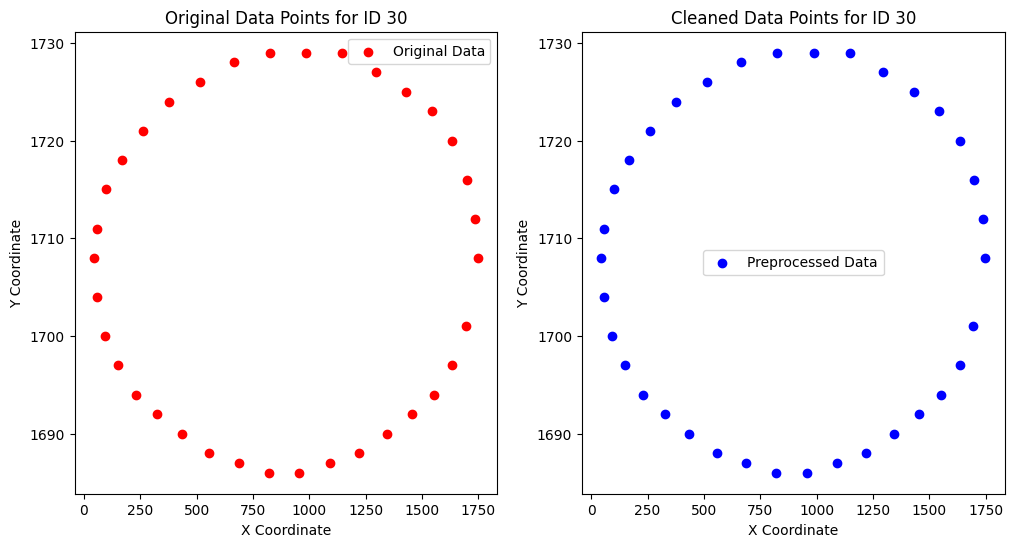

In [55]:
import matplotlib.pyplot as plt

# Assuming you have access to the original x, y data for ID 30
x_orig, y_orig = trajectories_x[1],trajectories_y[1]
x_clean, y_clean = preprocess_data(np.array(x_orig), np.array(y_orig))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(x_orig, y_orig, color='red', label='Original Data')
ax1.set_title('Original Data Points for ID 30')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.legend()

ax2.scatter(x_clean, y_clean, color='blue', label='Preprocessed Data')
ax2.set_title('Cleaned Data Points for ID 30')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.legend()

plt.show()


In [56]:
import numpy as np

# Assume trajectories_x and trajectories_y are lists of arrays
x = np.array(trajectories_x, dtype=object)
y = np.array(trajectories_y, dtype=object)

def clean_coordinates(x, y):
    cleaned_x = []
    cleaned_y = []
    for xi, yi in zip(x, y):
        try:
            # Convert to float and replace non-convertible types with NaN
            xi = np.array(xi, dtype=float)
            yi = np.array(yi, dtype=float)
        except ValueError:
            # Handle the case where conversion to float fails
            continue
        
        if xi.size > 0 and yi.size > 0:  # Check if arrays are not empty
            data = np.column_stack((xi, yi))
            # Remove rows with NaN or Inf
            cleaned_data = data[~(np.isnan(data).any(axis=1) | np.isinf(data).any(axis=1))]
            cleaned_x.append(cleaned_data[:, 0])
            cleaned_y.append(cleaned_data[:, 1])
    return cleaned_x, cleaned_y

# Clean x and y
x_cleaned, y_cleaned = clean_coordinates(x, y)

# Print cleaned data (Example: print first cleaned trajectory if exists)
if x_cleaned and y_cleaned:
    print("Cleaned x[0]:", x_cleaned[0])
    print("Cleaned y[0]:", y_cleaned[0])


Cleaned x[0]: [1749. 1737. 1699. 1633. 1543. 1428. 1294. 1145.  986.  824.  664.  513.
  376.  260.  166.   98.   57.   43.   56.   92.  152.  231.  327.  437.
  558.  687.  821.  957. 1091. 1221. 1344. 1456. 1554. 1635. 1696.]
Cleaned y[0]: [1821. 1826. 1832. 1837. 1841. 1846. 1849. 1851. 1853. 1853. 1852. 1849.
 1846. 1841. 1836. 1831. 1825. 1820. 1814. 1809. 1804. 1800. 1797. 1794.
 1791. 1790. 1790. 1790. 1791. 1792. 1795. 1798. 1801. 1805. 1810.]


M =  19
ID =  0
last sigma value =  45.75915735820308


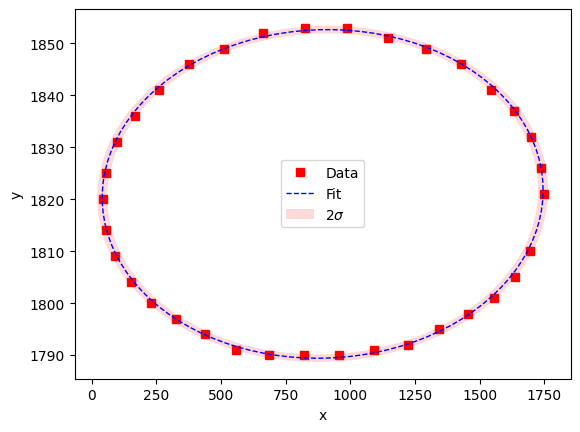

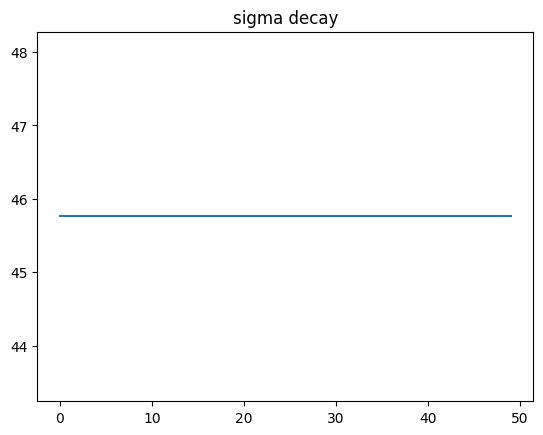

ID =  1
last sigma value =  16.10127883637324


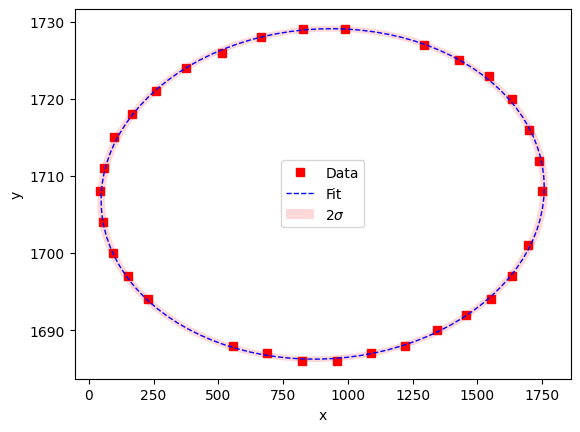

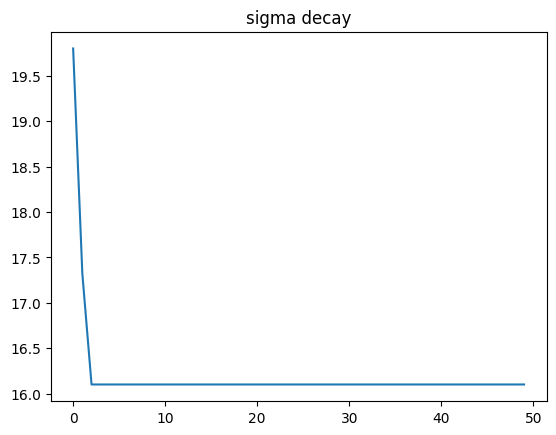

ID =  2
last sigma value =  7.8192289704456925


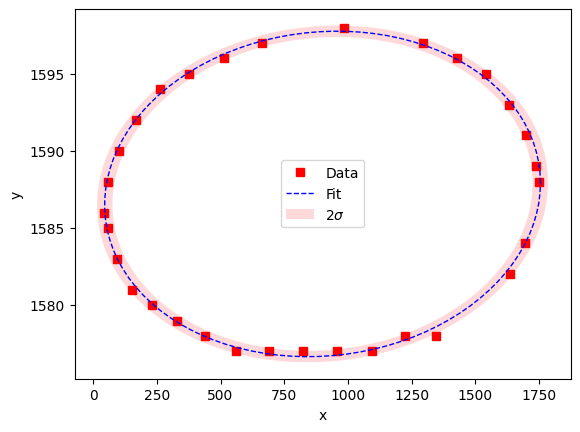

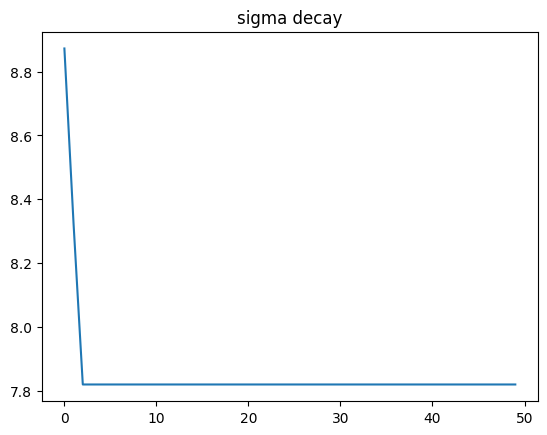

ID =  3
last sigma value =  72.50179015472531


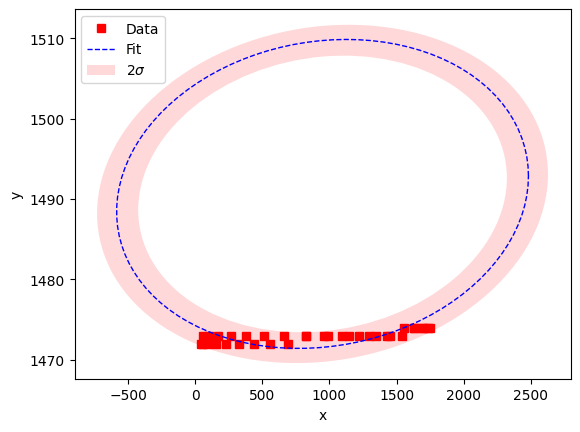

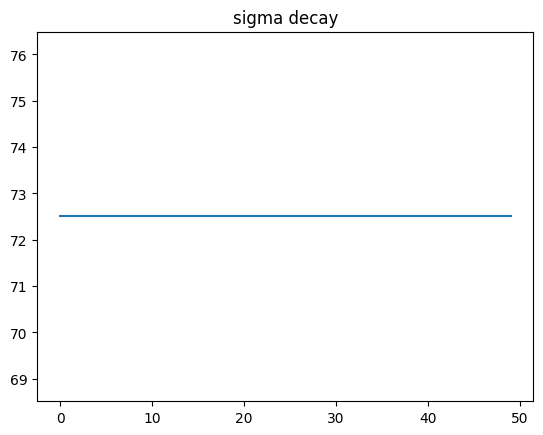

ID =  4
last sigma value =  5.063416653312743


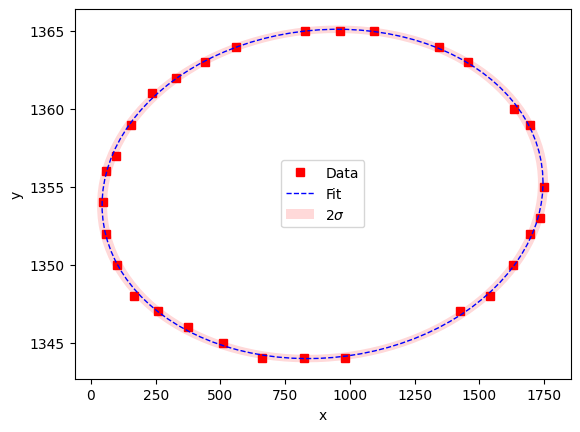

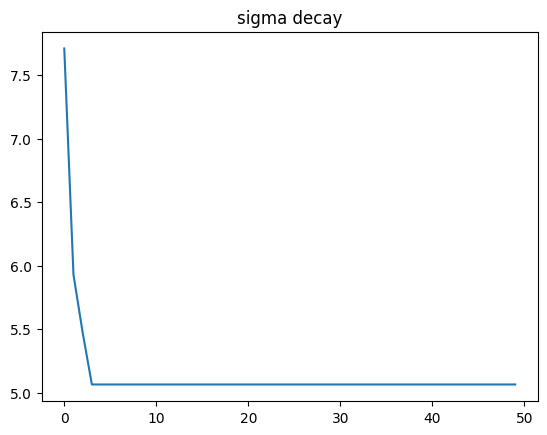

ID =  5
last sigma value =  11.213004062883556


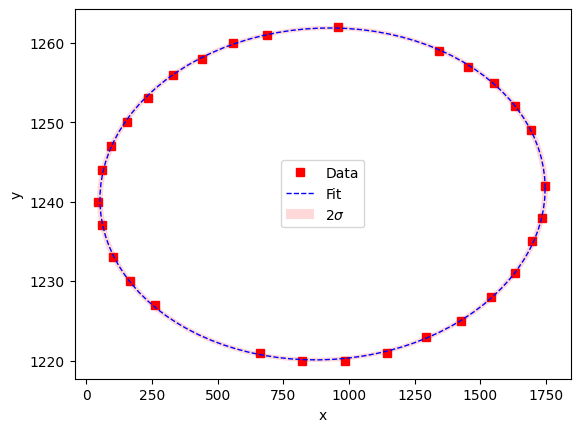

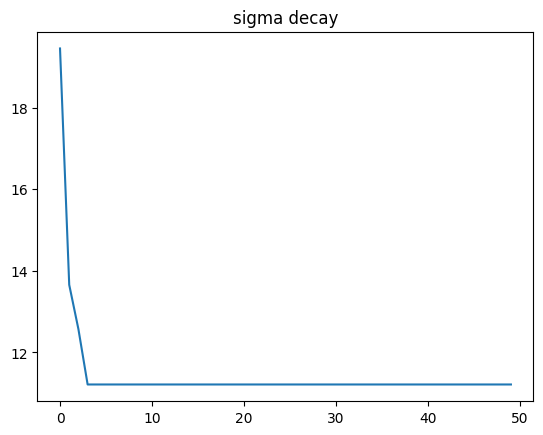

ID =  6
last sigma value =  22.138962229248136


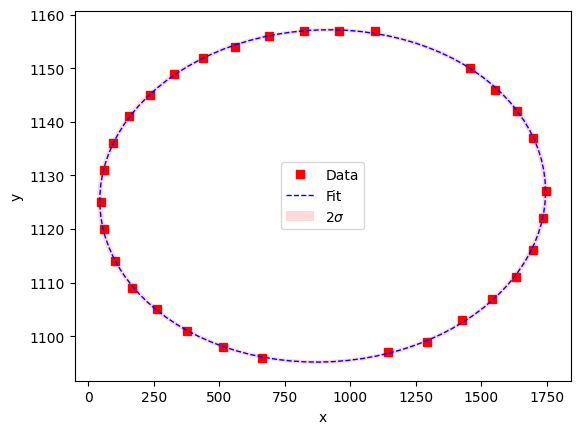

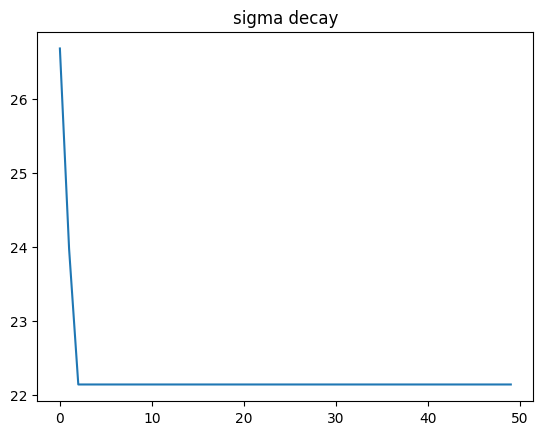

ID =  7
last sigma value =  24.310227104928344


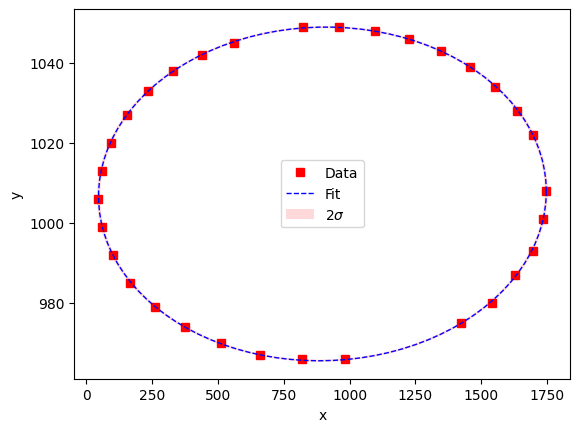

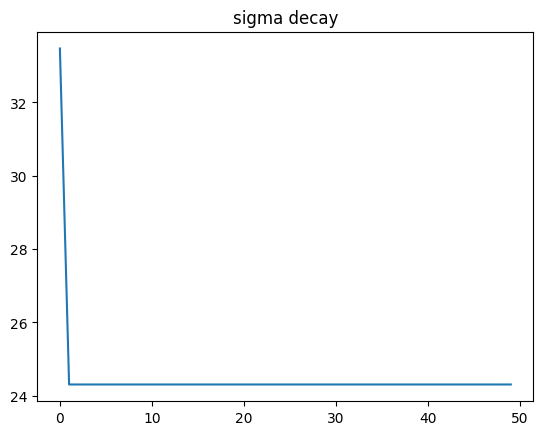

ID =  8
last sigma value =  50.17172697279602


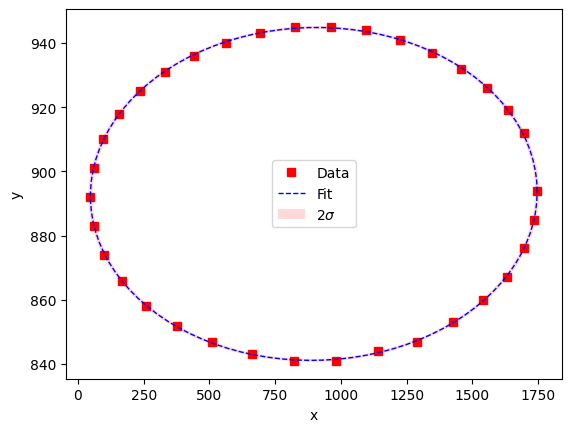

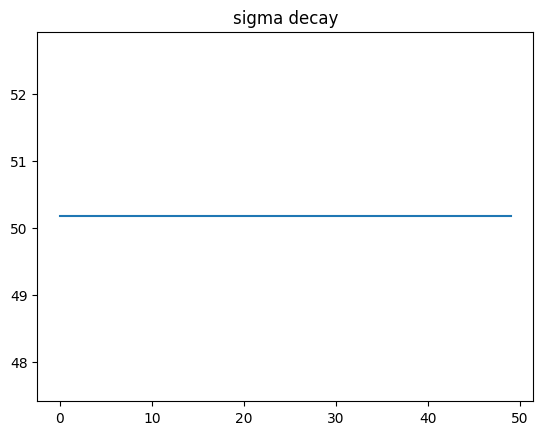

ID =  9
last sigma value =  62.557805856340565


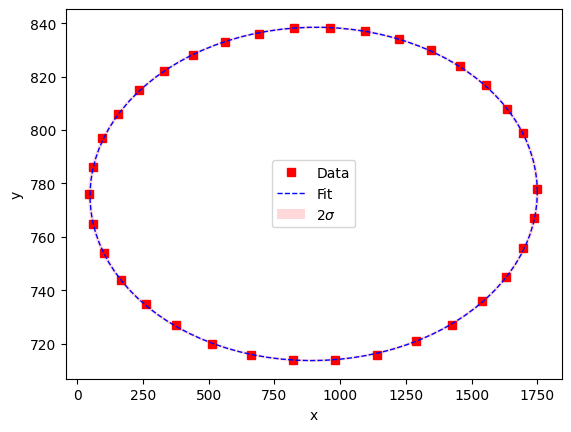

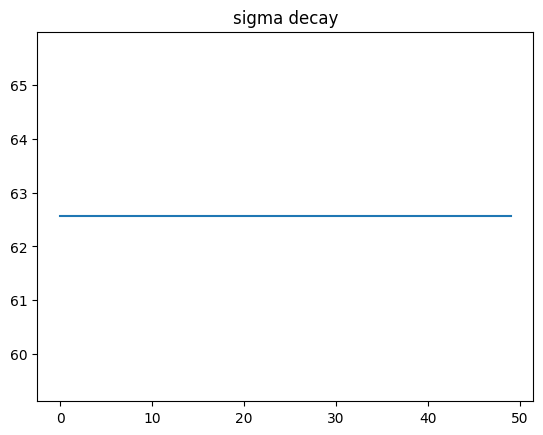

ID =  10
last sigma value =  63.594931144674774


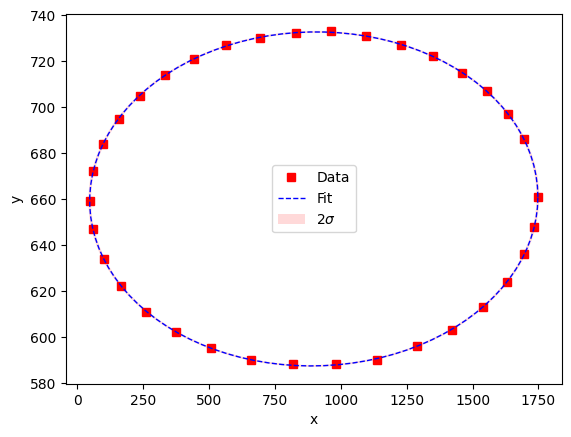

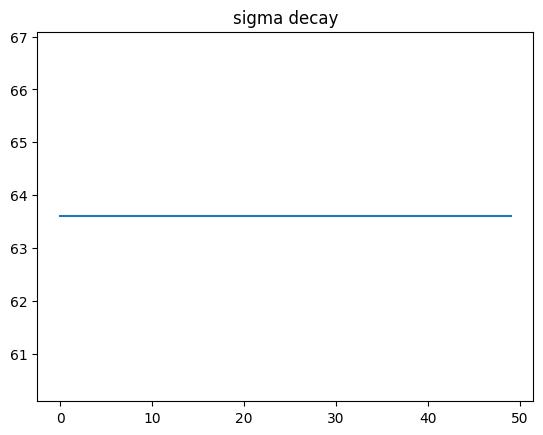

ID =  11
last sigma value =  75.79065155092394


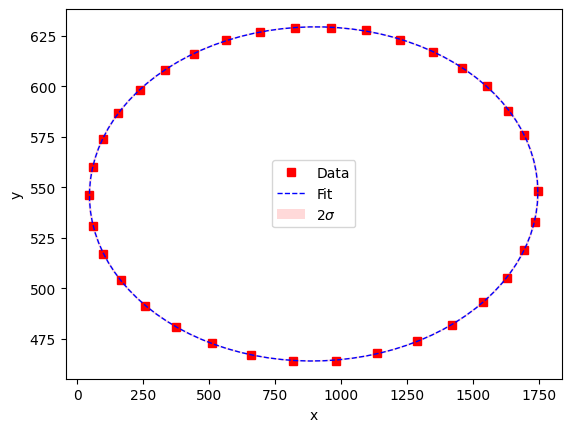

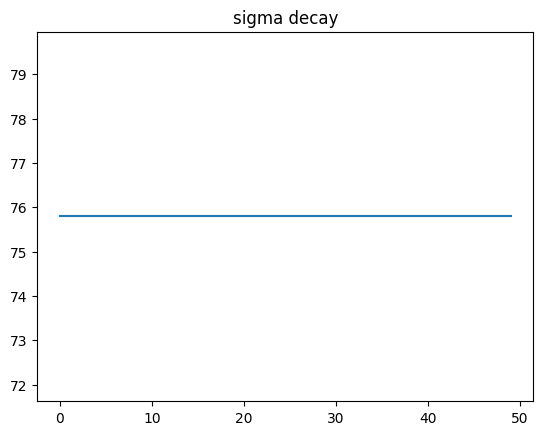

ID =  12
last sigma value =  67.89938234662986


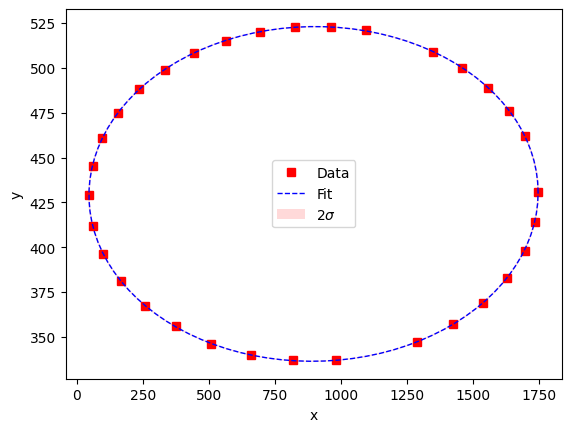

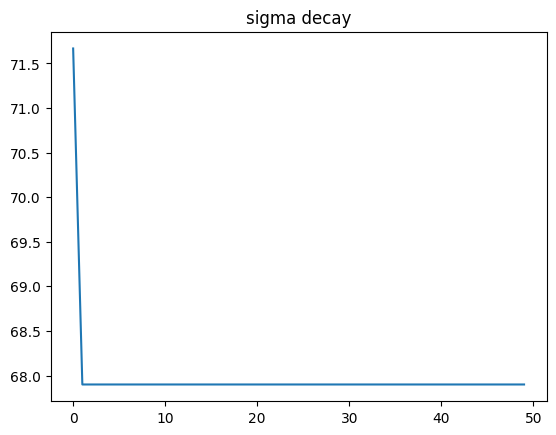

ID =  13
last sigma value =  79.9234172495635


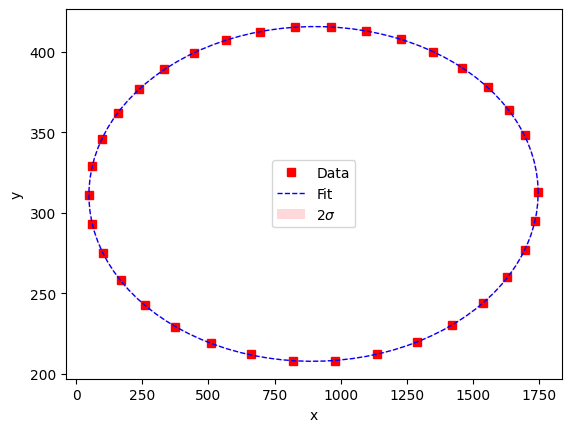

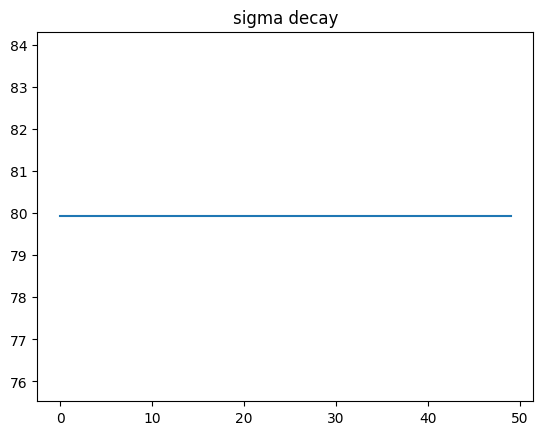

ID =  14
last sigma value =  77.82434300187742


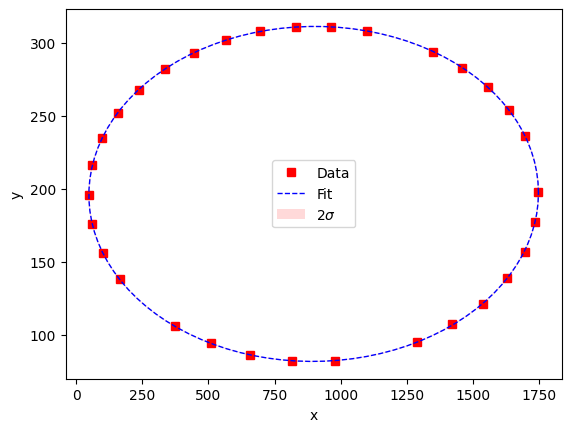

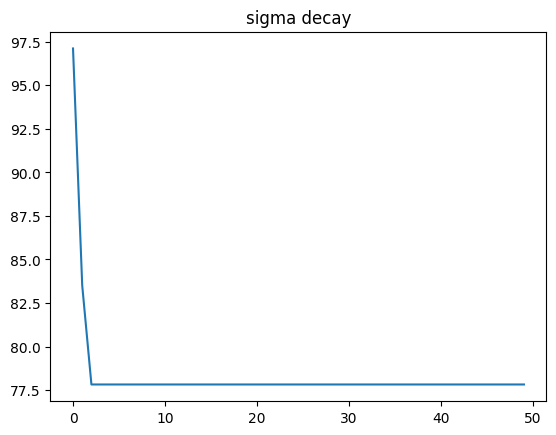

ID =  15
last sigma value =  166.80920642324418


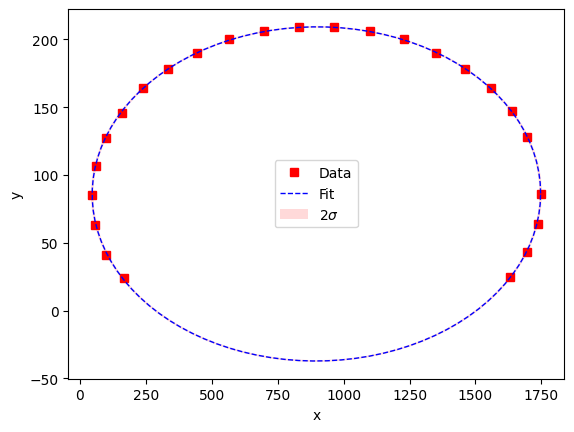

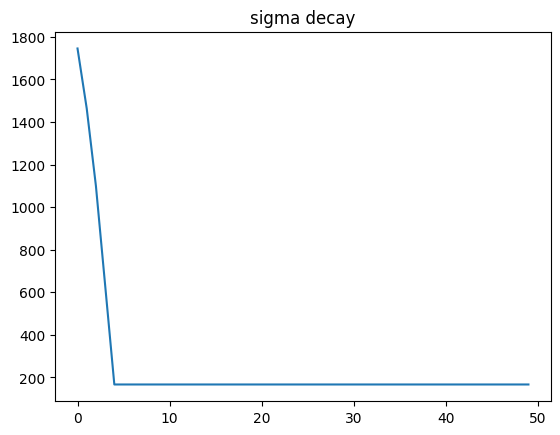

ID =  16
No valid ellipse found.


AttributeError: 'NoneType' object has no attribute 'size'

In [57]:
import matplotlib.patches as patches

# number of iterations for outlier removal
N = 50

ell_all = []
err_all = []
Sigma_all = [] 
M = len(trajectories_x)
print('M = ', M)

for iii in range(M):
    print('ID = ', iii)

    sigma_ell = []
    # x= trajectories_x[iii]
    # y= trajectories_y[iii]
    x = np.array(x_cleaned[iii])
    y = np.array(y_cleaned[iii])

    for ell_ii in range(N):
        # do fitting
        params1 = fit(x,y)
        params1 = errors(x,y,params1)

        center, a, b, phi = convert(params1)
        c_up, c_do = confidence_area(x,y,[i.n for i in params1],f=2) 
        if convert(c_do) > convert(c_up):
            c_do, c_up = c_up,c_do

        # do the outlier removal
        mask1 = artist(c_up,ec='none') 
        mask2 = artist(c_do,ec='none') 

        # The ellipse1
        g_ell_center = getattr(mask1, "center")
        g_ell_width = getattr(mask1, "width")
        g_ell_height = getattr(mask1, "height")
        angle = getattr(mask1, "angle")

        g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=angle, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse)

        cos_angle = np.cos(np.radians(180.-angle))
        sin_angle = np.sin(np.radians(180.-angle))

        xc = x - g_ell_center[0]
        yc = y - g_ell_center[1]

        xct = xc * cos_angle - yc * sin_angle
        yct = xc * sin_angle + yc * cos_angle 

        rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

        # The ellipse2
        g_ell_center2 = getattr(mask2, "center")
        g_ell_width2 = getattr(mask2, "width")
        g_ell_height2 = getattr(mask2, "height")
        angle2 = getattr(mask2, "angle")

        g_ellipse2 = patches.Ellipse(g_ell_center2, g_ell_width2, g_ell_height2, angle=angle2, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse2)

        cos_angle2 = np.cos(np.radians(180.-angle2))
        sin_angle2 = np.sin(np.radians(180.-angle2))

        xc = x - g_ell_center[0]
        yc = y - g_ell_center[1]

        xct = xc * cos_angle - yc * sin_angle
        yct = xc * sin_angle + yc * cos_angle 

        rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

                # The ellipse2
        g_ell_center2 = getattr(mask2, "center")
        g_ell_width2 = getattr(mask2, "width")
        g_ell_height2 = getattr(mask2, "height")
        angle2 = getattr(mask2, "angle")

        g_ellipse2 = patches.Ellipse(g_ell_center2, g_ell_width2, g_ell_height2, angle=angle2, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse2)

        cos_angle2 = np.cos(np.radians(180.-angle2))
        sin_angle2 = np.sin(np.radians(180.-angle2))

        xc2 = x - g_ell_center2[0]
        yc2 = y - g_ell_center2[1]

        xct2 = xc2 * cos_angle2 - yc2 * sin_angle2
        yct2 = xc2 * sin_angle2 + yc2 * cos_angle2 

        rad_cc2 = (xct2**2/(g_ell_width2/2.)**2) + (yct2**2/(g_ell_height2/2.)**2)
        

        # define new X and Y as modified
        xy_array = np.array([x,y])
        indices1 = np.where(rad_cc2 <= 1.)[0]
        if len(indices1) > 0:
            modified_array1 = np.delete(xy_array, indices1, 1)
            indices2 = np.intersect1d(np.where(rad_cc >= 1.)[0], np.arange(modified_array1.shape[1]))
            if len(indices2) > 0:
                modified_array2 = np.delete(modified_array1, indices2, 1)
                x = modified_array2[0]
                y = modified_array2[1]
            else:
                x = modified_array1[0]
                y = modified_array1[1]
        else:
            pass
  
        sigma =  abs(((c_up-c_do)/2)[5])
        sigma_ell.append(sigma)


    ell = convert(params1)
    ell_all.append(ell)

    # plot of fit and confidence area
    fig,ax = plt.subplots()
    ax.plot(x,y,'sr',label='Data')
    ax.plot(*line([i.n for i in params1]),'--b',lw=1,label='Fit')
    ax.add_patch(artist(c_up,ec='none',fc='r',alpha=0.15,label=r'2$\sigma$'))
    ax.add_patch(artist(c_do,ec='none',fc='white'))
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig2,ax2 = plt.subplots()
    ax2.plot(sigma_ell)
    plt.title('sigma decay')

    print('last sigma value = ', sigma_ell[-1])
    plt.show()


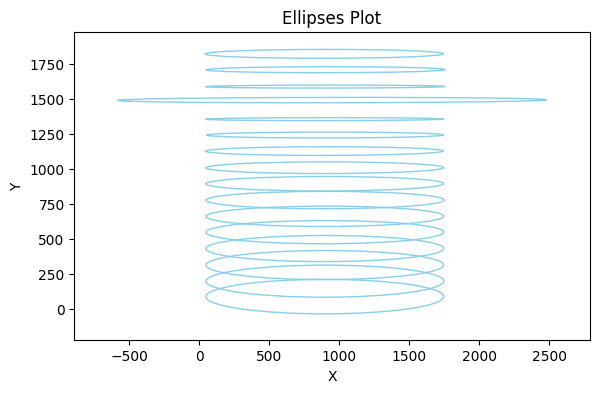

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ell_all_array = np.array(ell_all, dtype=object)
M = len(ell_all_array)

# Collect ellipse parameters
x_cen_nominal = np.array([un.nominal_value(ell_all_array[i][0][0]) for i in range(M)]).reshape(M, 1)
y_cen_nominal = np.array([un.nominal_value(ell_all_array[i][0][1]) for i in range(M)]).reshape(M, 1)
a_nominal_arr = np.array([un.nominal_value(ell_all_array[i][1]) for i in range(M)]).reshape(M, 1)
b_nominal_arr = np.array([un.nominal_value(ell_all_array[i][2]) for i in range(M)]).reshape(M, 1)
angles_nominal_arr = np.array([np.degrees(un.nominal_value(ell_all_array[i][3])) for i in range(M)]).reshape(M, 1)

# Plot all ellipses
fig, ax = plt.subplots(figsize=(10,4))
for i in range(M):
    center = (x_cen_nominal[i][0], y_cen_nominal[i][0])
    width = 2 * a_nominal_arr[i][0]
    height = 2 * b_nominal_arr[i][0]
    angle = angles_nominal_arr[i][0]
    ellipse = patches.Ellipse(center, width, height, angle=angle, fill=False, edgecolor='skyblue')
    ax.add_patch(ellipse)
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ellipses Plot')
ax.set_xlim(left=min(x_cen_nominal - 1.2 * a_nominal_arr), right=max(x_cen_nominal + 1.2 * a_nominal_arr))
ax.set_ylim(bottom=min(y_cen_nominal - 2.5 * b_nominal_arr), top=max(y_cen_nominal + 5 * b_nominal_arr))

plt.show()


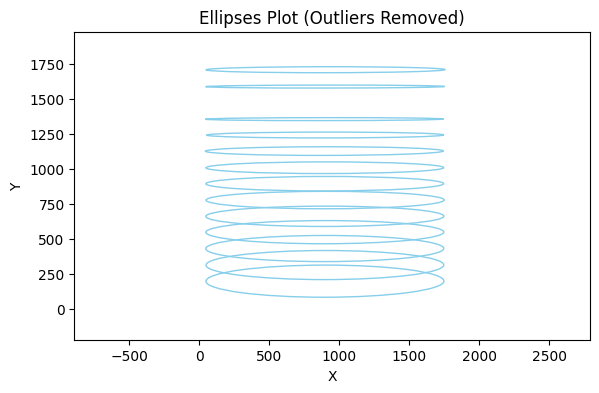

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import zscore

# Calculate Z-scores for each parameter
z_x_center = zscore(x_cen_nominal)
z_y_center = zscore(y_cen_nominal)
z_major_axis = zscore(a_nominal_arr)
z_minor_axis = zscore(b_nominal_arr)

# Define threshold Z-score value
threshold = 1.6

# Find outliers indices for each parameter
outliers_x_center = np.where(np.abs(z_x_center) > threshold)[0]
outliers_y_center = np.where(np.abs(z_y_center) > threshold)[0]
outliers_major_axis = np.where(np.abs(z_major_axis) > threshold)[0]
outliers_minor_axis = np.where(np.abs(z_minor_axis) > threshold)[0]

# Combine indices of all outliers
all_outliers = np.unique(np.concatenate((outliers_x_center, outliers_y_center, outliers_major_axis, outliers_minor_axis)))

# Remove outliers from the ellipse parameters
x_cen_nominal_clean = np.delete(x_cen_nominal, all_outliers)
y_cen_nominal_clean = np.delete(y_cen_nominal, all_outliers)
a_nominal_arr_clean = np.delete(a_nominal_arr, all_outliers)
b_nominal_arr_clean = np.delete(b_nominal_arr, all_outliers)
angles_nominal_arr_clean = np.delete(angles_nominal_arr, all_outliers)

# Plot the remaining ellipses
fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(x_cen_nominal_clean)):
    center = (x_cen_nominal_clean[i], y_cen_nominal_clean[i])
    width = 2 * a_nominal_arr_clean[i]
    height = 2 * b_nominal_arr_clean[i]
    angle = angles_nominal_arr_clean[i]
    ellipse = patches.Ellipse(center, width, height, angle=angle, fill=False, edgecolor='skyblue')
    ax.add_patch(ellipse)
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ellipses Plot (Outliers Removed)')
ax.set_xlim(left=min(x_cen_nominal - 1.2 * a_nominal_arr), right=max(x_cen_nominal + 1.2 * a_nominal_arr))
ax.set_ylim(bottom=min(y_cen_nominal - 2.5 * b_nominal_arr), top=max(y_cen_nominal + 5 * b_nominal_arr))
plt.show()


In [60]:
ell_all_array = np.array(ell_all,dtype=object)
M = ell_all_array.shape[0]
print('M:', M)
print(ell_all_array.shape)
print(len(ell_all_array))
print(ell_all_array[0][0][0])

M: 16
(16, 4)
16
892.9+/-2.7


In [61]:
x_cen_nominal_clean = np.delete(x_cen_nominal, all_outliers)
y_cen_nominal_clean = np.delete(y_cen_nominal, all_outliers)
a_nominal_arr_clean = np.delete(a_nominal_arr, all_outliers)
b_nominal_arr_clean = np.delete(b_nominal_arr, all_outliers)
angles_nominal_arr_clean = np.delete(angles_nominal_arr, all_outliers)

In [ ]:
x_cen_nominal_clean

In [ ]:
y_cen_nominal_clean

In [ ]:
a_nominal_arr_clean

In [ ]:
b_nominal_arr_clean

In [62]:
heights = y_cen_nominal_clean[:]
x_centers = x_cen_nominal_clean[:]
y_centers = y_cen_nominal_clean[:]
major_axes = a_nominal_arr_clean[:]
minor_axes = b_nominal_arr_clean[:]
angles = angles_nominal_arr_clean[:]



In [ ]:
np.array(minor_axes).shape

In [ ]:
angles

The values in the list you provided are likely in radians. This inference is based on their range; angle values in radians for common rotations typically fall within the interval 
0
0 to 
𝜋
π (approximately 
0
0 to 
3.14
3.14), which matches the scale of your data.

In trigonometry, radians are a standard unit of angular measurement, used extensively in mathematical calculations. An angle's radian measure is the length of the arc created by the angle on a circle of radius one. Here's a quick conversion context:

𝜋
π radians is equal to 180 degrees.
2
𝜋
2π radians is equal to 360 degrees.
The values you listed are all considerably less than 
𝜋
π, suggesting they represent relatively small angles. Here's a quick example to help illustrate:

0.03652918
0.03652918 radians, when converted to degrees, is 
0.03652918
×
180
𝜋
≈
2.09
0.03652918× 
π
180
​
 ≈2.09 degrees.
This fits with typical scenarios where smaller angular displacements are used in calculations or measurements, making radians a plausible unit for your data. If you need to use these angle values in a context requiring degrees, you can convert them using the conversion factor 
180
𝜋
π
180
​
 .








In [ ]:
heights

In [ ]:
x_centers

In [ ]:
y_centers

In [ ]:
minor_axes

In [ ]:
major_axes

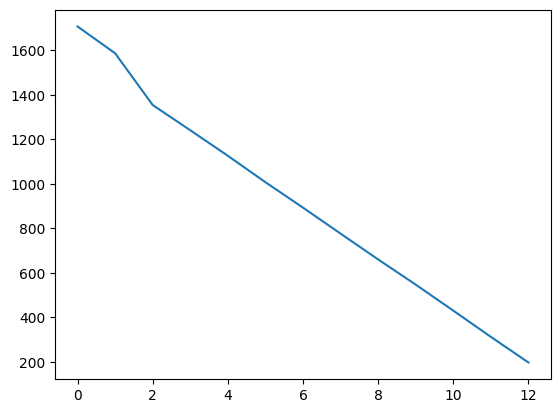

In [63]:
plt.plot(heights)

In [ ]:
plt.plot(y_centers)

In [ ]:
plt.plot(x_centers)

In [ ]:
plt.plot(major_axes)

In [ ]:
plt.plot(minor_axes)

In [ ]:
plt.plot(angles)

the ellipses are in the beam direction. Actually they are representing the cone beam shape. the piercing point is the projection of this intersecting spatial point (with x,y,z coordinates) to the plane perpendicular to the beam direction at the piercing point.  


To calculate the piercing point of the cone beam on the plane perpendicular to the beam direction.

First, we need to find the equation of the plane perpendicular to the beam direction at the piercing point. We can do this by using the direction vector of the beam, which we can assume is known, and the coordinates of the piercing point.

Next, we can find the intersection points of the minor axis vectors with this plane. We can do this by finding the equations of the lines that pass through the center of each ellipse and are parallel to the minor axis vector. Then we can find the intersection of each of these lines with the plane perpendicular to the beam direction.

Finally, we can take the average of these intersection points to get the coordinates of the piercing point.

Here's a step-by-step procedure:

Let's assume that the beam direction vector is given by B = [Bx, By, Bz] and the coordinates of the piercing point are P = [Px, Py, Pz]. The equation of the plane perpendicular to the beam direction passing through P can be written as:

Bx(x - Px) + By(y - Py) + Bz(z - Pz) = 0

This is equivalent to:

Bxx + Byy + Bzz = BxPx + ByPy + BzPz

To find the intersection points of the minor axis vectors with this plane. Suppose the center of the i-th ellipse is Ci = [Cix, Ciy, Ciz], and the vector corresponding to the minor axis of the ellipse is Mi = [Mix, Miy, Mlz]. We can find the equation of the line passing through Ci and parallel to Mi as:

x = Cix + tMix
y = Ciy + tMiy
z = Ciz + t*Mlz

where t is a scalar parameter.

To find the intersection point of this line with the plane perpendicular to the beam direction, we can substitute the equation of the line into the equation of the plane and solve for t. This gives:

t = (BxCix + ByCiy + BzCiz - BxPx - ByPy - BzPz) / (BxMix + ByMiy + Bz*Mlz)

Once we have t, we can substitute it back into the equation of the line to find the intersection point:

Ii = [Cix + tMix, Ciy + tMiy, Ciz + t*Mlz]

Finally, we can take the average of all the intersection points to get the coordinates of the piercing point:

Pp = (I1 + I2 + ... + In) / n

where n is the number of ellipses.

If you have the ellipse parameters for each slice, you can use them to calculate the source position. Here's one possible approach:

Assume the x-ray source is located at point S(x, y, z) in 3D space.
For each ellipse in the image, compute its major and minor axis lengths (a and b, respectively), as well as its center coordinates (xc, yc).
Project the center of the ellipse onto the plane perpendicular to the beam direction (i.e., the plane passing through the piercing point). This can be done by subtracting the dot product of the vector from the piercing point to the source with the normal vector of the plane from the center coordinates of the ellipse. The resulting vector will be the displacement vector from the piercing point to the center of the ellipse in the plane.
Normalize the vector obtained in step 3 and multiply it by the distance from the piercing point to the source (which you do not have yet).
Add the resulting vector to the coordinates of the piercing point to obtain the coordinates of the source.
Step 4 requires knowing the distance from the piercing point to the source. One way to estimate this distance is to use the known magnification of the imaging system. The magnification M is defined as the ratio of the distance from the source to the object (SOD) and the distance from the object to the detector (SDD): M = SOD/SDD. If you know the SDD and the magnification, you can compute the SOD as SOD = SDD/M. Once you have the SOD, you can use the Pythagorean theorem to compute the distance from the piercing point to the source as D = sqrt(SOD^2 + (xc-x)^2 + (yc-y)^2).

Alternatively, if you have access to other information about the imaging system (e.g., the geometry of the x-ray source and detector), you may be able to estimate the distance from the piercing point to the source more accurately.

We calculate the endpoints of line segments based on the center coordinates (x_centers and y_centers), minor axes (minor_axes), and angles (angles) of each ellipse. Then, we plot these line segments on a plot.

Here's a breakdown of what each part does:

- Calculating Line Endpoints:
The loop iterates over each ellipse.
For each ellipse, it calculates the coordinates of two endpoints of a line segment.
The starting point of the line segment is the center of the ellipse (x_centers[i], y_centers[i]).
The endpoint of the line segment is calculated by adding the minor axis length (minor_axes[i]) in the direction defined by the angle (angles[i]). This calculation involves trigonometric functions to determine the coordinates of the endpoint based on the angle.
- Plotting Line Segments:
After calculating all the endpoints, it plots each line segment on the plot.
The loop iterates over the list of line endpoints (line_points).
For each endpoint pair [x0, y0, x1, y1], it plots a line segment from (x0, y0) to (x1, y1) with a red color.
- Plotting the Results:
Finally, it displays the plot with all the line segments.
This code is useful for visualizing the orientation and size of the minor axes of each ellipse. It helps to understand the distribution and arrangement of the ellipses in the plot.

In [64]:

# Calculate endpoints of line segments
line_points = []
for i in range(len(x_centers)):
    x0 = y_centers[i]
    y0 = x_centers[i]
    x1 = x0 + minor_axes[i] * np.cos((angles[i]))
    y1 = y0 + minor_axes[i] * np.sin((angles[i]))
    line_points.append([x0, y0, x1, y1])
line_points = np.array(line_points)


In [ ]:
line_points.shape

In [ ]:
line_points

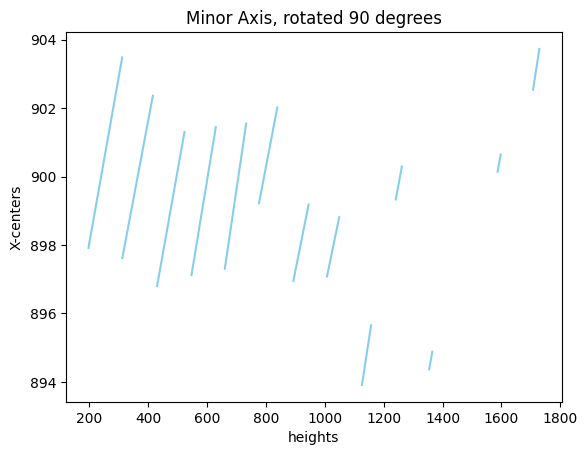

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for x0, y0, x1, y1 in line_points:
    ax.plot([x0, x1], [y0, y1], color='skyblue')

# Set Y-axis limits
# ax.set_ylim(800, 990)  # Adjust the limits as needed

ax.set_title('Minor Axis, rotated 90 degrees')
ax.set_xlabel('heights')  # Label for the y-axis
ax.set_ylabel('X-centers')  # Label for the x-axis

plt.show()



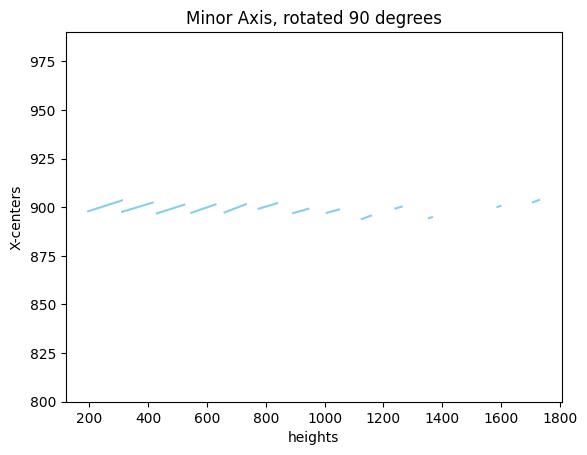

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for x0, y0, x1, y1 in line_points:
    ax.plot([x0, x1], [y0, y1], color='skyblue')

# Set Y-axis limits
ax.set_ylim(800, 990)  # Adjust the limits as needed

ax.set_title('Minor Axis, rotated 90 degrees')
ax.set_xlabel('heights')  # Label for the y-axis
ax.set_ylabel('X-centers')  # Label for the x-axis

plt.show()



To compute the length of the line segments and filter out those that fall within the 1st quarter of the length distribution, you can follow these steps:

Calculate the length of each line segment.
Find the 25th percentile of the length distribution.
Keep only the line segments whose length is less than or equal to the 25th percentile value.

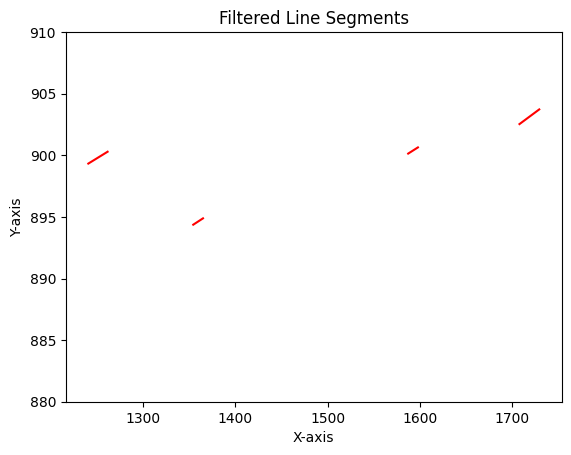

In [67]:
import numpy as np
from scipy.stats import scoreatpercentile

# Calculate the length of each line segment
segment_lengths = np.sqrt((line_points[:, 2] - line_points[:, 0])**2 + (line_points[:, 3] - line_points[:, 1])**2)

# Find the 25th percentile of the length distribution
percentile_25 = scoreatpercentile(segment_lengths, 25)

# Filter out line segments in the 1st quarter of the length distribution
filtered_line_points = line_points[segment_lengths <= percentile_25]

# Plot the filtered line segments
fig, ax = plt.subplots()

for x0, y0, x1, y1 in filtered_line_points:
    ax.plot([x0, x1], [y0, y1], color='red')

ax.set_title('Filtered Line Segments')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_ylim(880, 910)
plt.show()


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from ipywidgets import interactive
from mpl_toolkits.mplot3d import Axes3D

# Global variables to hold the minimum point and value
global_min_point = None
global_min_value = None


# Prepare data for fitting
X = line_points[:, :2]  # Take the starting points of the lines
Y = minor_axes  # Corresponding minor axis lengths


# Higher-order model definition
def higher_order_model(xy, *coeffs):
    x, y = xy
    degree = 5  # Adjust based on the actual complexity of your model
    result = np.zeros_like(x)
    index = 0
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            result += coeffs[index] * (x ** i) * (y ** j)
            index += 1
    return result

# Prepare data for fitting
X = line_points[:, :2]  # Take the starting points of the lines
Y = minor_axes  # Corresponding minor axis lengths

# Define the initial guesses for the coefficients
degree = 5
num_coeffs = (degree + 1) * (degree + 2) // 2
initial_guess = np.zeros(num_coeffs)

# Fit the higher-order polynomial model
params, params_covariance = curve_fit(lambda xy, *params: higher_order_model(xy, *params), X.T, Y, p0=initial_guess)

# Objective function for minimization
def objective(xy):
    return higher_order_model(xy, *params)

# Set bounds for the optimization to realistic values
bounds = [(X[:,0].min(), X[:,0].max()), (X[:,1].min(), X[:,1].max())]

# Minimization to find the global minimum
result = minimize(objective, x0=[(X[:,0].min() + X[:,0].max()) / 2, (X[:,1].min() + X[:,1].max()) / 2], bounds=bounds)
global_min_point = result.x
global_min_value = result.fun

def update_plot(elev=30, azim=30):
    global global_min_point, global_min_value
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate grid for surface
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x_range, y_range = np.meshgrid(x_range, y_range)
    z_range = higher_order_model((x_range.ravel(), y_range.ravel()), *params).reshape(100, 100)

    ax.plot_surface(x_range, y_range, z_range, alpha=0.5, rstride=10, cstride=10, color='skyblue')
    ax.scatter(X[:, 0], X[:, 1], Y, color='c', s=50)  # Plot data points

    # Highlight the minimum point
    ax.scatter(result.x[0], result.x[1], result.fun, color='r', s=100, marker='*')

    # Set labels and title
    ax.set_title('Fitted Higher-Order Polynomial Surface with Minimum Point')
    ax.set_xlabel('X coordinates')
    ax.set_ylabel('Y coordinates')
    ax.set_zlabel('Minor Axis Lengths')

    # Set viewing angle
    ax.view_init(elev=elev, azim=azim)
    plt.show()
# Access global minimum point and value from outside
print("Accessed outside the function - Minimum point:", global_min_point)
print("Accessed outside the function - Minimum value:", global_min_value)
# Use interactive widget to adjust view angles
interactive_plot = interactive(update_plot, elev=(0, 90), azim=(0, 360))
interactive_plot



TypeError: The number of func parameters=21 must not exceed the number of data points=13

In [69]:
def higher_order_model(xy, degree, *coeffs):
    x, y = xy
    result = np.zeros_like(x)
    index = 0
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            result += coeffs[index] * (x ** i) * (y ** j)
            index += 1
    return result

# Define the initial guesses for the coefficients
degree = 5
num_coeffs = (degree + 1) * (degree + 2) // 2
initial_guess = np.zeros(num_coeffs)

# Fit the higher-order polynomial model
params, params_covariance = curve_fit(lambda xy, *coeffs: higher_order_model(xy, degree, *coeffs), X.T, Y, p0=initial_guess)

# Example of using the fitted model (you can adapt this part as needed)
x_range = np.linspace(X[:,0].min(), X[:,0].max(), 100)
y_range = np.linspace(X[:,1].min(), X[:,1].max(), 100)
x_range, y_range = np.meshgrid(x_range, y_range)
z_range = higher_order_model((x_range.ravel(), y_range.ravel()), degree, *params).reshape(100, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(x_range, y_range, z_range, levels=50, cmap='plasma')
ax.scatter(X[:, 0], X[:, 1], c='skyblue')
ax.set_title('Fitted Surface')
plt.show()




TypeError: The number of func parameters=21 must not exceed the number of data points=13

In [ ]:
global_min_value

In [ ]:
global_min_point

result.x: This attribute stores the array of values that represent the solution—i.e., the values of the variables that minimize the objective function. For the context of your problem, if you are minimizing a function that depends on x and y coordinates (as in a surface fitting problem), result.x would contain the optimized x and y values where the function reaches its minimum.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
fig, ax = plt.subplots(figsize=(3.5, 5))

# Generate a color map
cmap = plt.get_cmap('RdYlBu_r')

# Number of trajectories
num_trajectories = len(trajectories)
colors = cmap(np.linspace(0, 1, num_trajectories))

# Plot each trajectory with its color
for index, (ID, data) in enumerate(trajectories.items()):
    if data[1] is not None:
        x, y = data[0][:, 0], data[0][:, 1]
        ax.scatter(x, y, s=20, color=colors[index], marker='o', label=f'Bead {ID}')

# Scatter plot for global minimum point (assuming you have defined global_min_point)
ax.scatter(global_min_point[1], global_min_point[0], marker='*', s=300, color='red')

# Optional: If you want to label the global minimum point
ax.text(global_min_point[1], global_min_point[0], ' Piercing point', color='black', ha='right')

# Set labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Bead Trajectories with Global Minimum')

# Show legend if you want to identify the beads by their ID
# plt.legend(title="Bead ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(3.5, 5))
ax.imshow(lcal[2], vmin=-0.03, vmax=0.4, cmap='gray')

# Generate a color map
cmap = plt.get_cmap('RdYlBu_r')

# Number of trajectories
num_trajectories = len(trajectories)
colors = cmap(np.linspace(0, 1, num_trajectories))

# Plot each trajectory with its color
for index, (ID, data) in enumerate(trajectories.items()):
    if data[1] is not None:
        x, y = data[0][:, 0], data[0][:, 1]
        ax.scatter(x, y, s=20, color=colors[index], marker='o', label=f'Bead {ID}')

# Scatter plot for global minimum point (assuming you have defined global_min_point)
ax.scatter(global_min_point[1], global_min_point[0], marker='*', s=300, color='red')

# Optional: If you want to label the global minimum point
ax.text(global_min_point[1], global_min_point[0], ' Global Min', color='white', ha='right')

# Set labels and title
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Overlay of Bead Trajectories on Image')

# Show legend if you want to identify the beads by their ID
# plt.legend(title="Bead ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
global_min_point[0]

In [ ]:
result.x[0]

In [ ]:
lcal.shape[1]-result.x[0]


In [ ]:
lcal.shape[1]

# COR

16
outlier values:  [array([1821.027224]), array([1707.67047059]), array([1587.21033011]), array([1490.63647601])]
[[-0.00103334]]
number of pixels the center of rotation deviated from top to bottom of the tomogram:  5.415746858861553
Center of rotation vertical:  897.1277559784324
Tilt slope:  [-0.00103334]
The tilt of the center of rotation in degrees:  [[-0.05920571]]


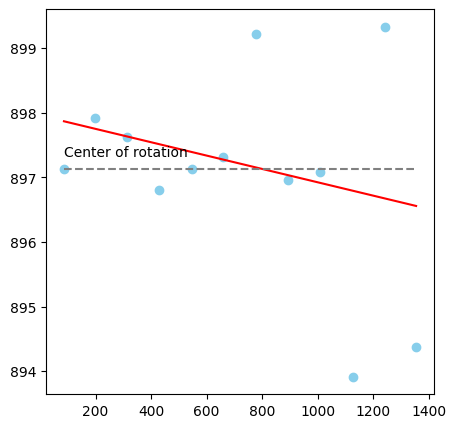

In [70]:
import uncertainties as un

x_centres=[]
y_centres=[]

for i in range(len(ell_all_array)):
    x_centres.append(ell_all_array[i][0][1])
    y_centres.append(ell_all_array[i][0][0])
    

arr_x = np.array(x_centres)

arr_x_nominal = []
arr_x_std = []
for iii in range(len(un.nominal_value(arr_x))):
    arr_x_nominal.append(un.nominal_value(un.nominal_value(arr_x)[iii]))
    arr_x_std.append(un.std_dev(un.nominal_value(arr_x)[iii]))
    
print(len(arr_x_nominal))

arr_x_nominal_arr = np.array(arr_x_nominal).reshape(M,1)

arr_x_std_arr = np.array(arr_x_std).reshape(M,1)



arr_y = np.array(y_centres)

arr_y_nominal = []
arr_y_std = []
for iii in range(len(un.nominal_value(arr_y))):
    arr_y_nominal.append(un.nominal_value(un.nominal_value(arr_y)[iii]))
    arr_y_std.append(un.std_dev(un.nominal_value(arr_y)[iii]))
arr_y_nominal_arr = np.array(arr_y_nominal).reshape(M,1)
arr_y_std_arr = np.array(arr_y_std).reshape(M,1)


# Removing the outlier in the data 
elements_x = arr_x_nominal_arr
elements_y = arr_y_nominal_arr


median_x = np.median(elements_x, axis=0)
sd_x = np.std(elements_x, axis=0)

outlier_x = [x for x in elements_x if (x > median_x + 1 * sd_x)]
print('outlier values: ', outlier_x)



for i in range(len(outlier_x)):
    index_x = np.where(elements_x == outlier_x[i-1])
    final_list_x_1 = np.array(np.delete(elements_x, index_x)).reshape(-1, 1)
    final_list_y_1 = np.array(np.delete(elements_y, index_x)).reshape(-1, 1)
    index_x_2 = np.where(final_list_x_1 == outlier_x[i])
    final_list_x = np.array(np.delete(final_list_x_1, index_x_2)).reshape(-1, 1)
    final_list_y = np.array(np.delete(final_list_y_1, index_x_2)).reshape(-1, 1)


    
s = minor_axes.reshape(minor_axes.shape[0],1)

# Using RANSACRegressor for minimum sensitivity to the outliers      
from sklearn.linear_model import RANSACRegressor  # https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/


ransac = RANSACRegressor(random_state=10).fit(final_list_x, final_list_y)
plotline_y = np.arange(final_list_x.min(), final_list_x.max()).reshape(-1, 1)
a = ransac.predict(plotline_y)
ransac_coef = ransac.estimator_.coef_
print(ransac_coef)


# print(final_list_y.shape)
# print(final_list_x.shape)
devaition_range = final_list_y.max()- final_list_y.min()
print('number of pixels the center of rotation deviated from top to bottom of the tomogram: ', np.abs(devaition_range))
COR_new = np.median(final_list_y) 
print('Center of rotation vertical: ', COR_new)
# form above (cell) estimation:
print('Tilt slope: ', ransac_coef.ravel())
# print('Tilt degree: ', ransac_coef.ravel())

#### Final value of COR can be obtained by subtractin of the projection value taken 
tilt_angle = np.degrees(np.arctan(ransac_coef))
print("The tilt of the center of rotation in degrees: ", tilt_angle)
fig,ax=plt.subplots(figsize=(5,5))
plt.plot(plotline_y,a,'r')
plt.scatter(final_list_x, final_list_y,color='skyblue')
plt.hlines(COR_new, xmin = final_list_x.min() , xmax =final_list_x.max() , colors='gray', linestyles='--', label='')
plt.text(final_list_x.min(), COR_new+0.2, 'Center of rotation');


In [ ]:

vpiercing = global_min_point[1]

hpiercing= global_min_point[0]


In [ ]:
vpiercing

### SSD and SOD

In [ ]:
# import numpy as np
# import uncertainties as un

# pixelSize = 0.138   # mm
# R = 10              # mm
# # c0=itemList(findBeadsWS(tcal[0,:,:]))
# sod = []
# sdd = []
# mag = []
# cte = pixelSize/R
# for idx in range(x_centers.shape[0]) :
#     ha=((y_centers[idx]-(minor_axes[idx]*np.cos(angles[idx]))-hpiercing) * pixelSize)
#     hb=((y_centers[idx]+(minor_axes[idx]*np.cos(angles[idx]))-hpiercing) * pixelSize)
# #     h=0
# #     if idx in range(ell_all_array.shape[0]) :
# #         h = (c0[idx][0]-vpiercing)*pixelSize
#     est_sod= (hb+ha)*R/((hb-ha)+0.0000000000001)
# #     est_sdd= ((est_sod-R)*hb)/h
#     sod.append(np.abs(est_sod))
# #     sdd.append(np.abs(est_sdd))
# #     print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format,(h,est_sod, est_sdd,est_sdd/est_sod))

#     magnification_each_elipse = cte * (ell_all_array[idx][1]) 
#     sdd_each_elipse = magnification_each_elipse * est_sod
#     sdd.append(np.abs(sdd_each_elipse))
#     mag.append(magnification_each_elipse)


# sod_mean = np.median([un.nominal_value(x) for x in sod])
# sdd_mean = np.median([un.nominal_value(x) for x in sdd])
# mag_mean = np.median([un.nominal_value(x) for x in mag])
# mag_ratio = sdd_mean/sod_mean

# print("SOD median= ", un.nominal_value(sod_mean))
# print("SDD median= ", un.nominal_value(sdd_mean))
# print("Magnification median= ", mag_mean)
# print("Magnification ratio= ",mag_ratio)

# index = []
# sod_nominal = []
# for i in range(len(sod)):
#     sod_nominal.append(un.nominal_value(np.mean(sod[i])))
#     index.append(np.argmin(un.nominal_value(np.mean(sod[i])))+1)
# sod_nominal_array = np.array(sod_nominal)    
# sod_mean2 = np.mean(sod_nominal)
# sod_std = np.std(sod_nominal)
# print('SOD stdev= ',sod_std)
# plt.boxplot(sod_nominal)
# plt.plot(1, sod_mean2,'sr')
# plt.scatter(index, sod_nominal)
# plt.title("sod")


# index2 = []
# sdd_nominal = []
# for i in range(len(sdd)):
#     sdd_nominal.append(un.nominal_value(np.mean(sdd[i])))
#     index2.append(np.argmin(un.nominal_value(np.mean(sdd[i])))+1)
# sdd_nominal_array = np.array(sdd_nominal)    
# sdd_mean2 = np.mean(sdd_nominal)
# sdd_std = np.std(sdd_nominal)
# print('SDD stdev= ', sdd_std)
# fig, ax = plt.subplots()
# ax.boxplot(sdd_nominal)
# ax.plot(1, sdd_mean2,'sr')
# ax.scatter(index2, sdd_nominal)
# plt.title("sdd")  

# print("SOD mean= ", sod_mean2)
# print("SDD mean= ",sdd_mean2)


Identify Outliers: Define outliers as values that are more than 25% away from the median.
Remove Outliers: Filter out these outliers from your dataset.
Compute the Median: Calculate the median of the cleaned dataset.
Plot the Results: Use matplotlib to plot the results to visualize the cleaned data and the computed median.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import uncertainties as un

# Constants
pixelSize = 0.138   # mm
R = 10              # 25 mm for new calibration sample
cte = pixelSize / R

# Sample data (assuming y_centers, minor_axes, angles, and vpiercing are defined)
sod = []
sdd = []
mag = []

# Compute values
for idx in range(x_centers.shape[0]):
    ha = ((y_centers[idx] - (minor_axes[idx] * np.cos(angles[idx])) - hpiercing) * pixelSize)
    hb = ((y_centers[idx] + (minor_axes[idx] * np.cos(angles[idx])) - hpiercing) * pixelSize)
    est_sod = (hb + ha) * R / ((hb - ha) + 1e-10)
    sod.append(np.abs(est_sod))

    magnification_each_elipse = cte * (ell_all_array[idx][1]) 
    sdd_each_elipse = magnification_each_elipse * est_sod
    sdd.append(np.abs(sdd_each_elipse))
    mag.append(magnification_each_elipse)

# Convert sod, sdd, mag to numpy arrays
sod = np.array([un.nominal_value(x) for x in sod])
sdd = np.array([un.nominal_value(x) for x in sdd])
mag = np.array([un.nominal_value(x) for x in mag])

# Remove outliers
def remove_outliers(data):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)
    iqr = upper_quartile - lower_quartile
    upper_bound = median + 0.25 * iqr
    lower_bound = median - 0.25 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

sod_clean = remove_outliers(sod)
sdd_clean = remove_outliers(sdd)
mag_clean = remove_outliers(mag)

# Compute medians and means
sod_median = np.median(sod_clean)
sdd_median = np.median(sdd_clean)
mag_median = np.median(mag_clean)

sod_mean = np.mean(sod_clean)
sdd_mean = np.mean(sdd_clean)
mag_mean = np.mean(mag_clean)

# Plotting
plt.figure(figsize=(4, 9))
plt.subplot(311)
plt.boxplot(sod_clean, positions=[1])
plt.scatter(np.ones_like(sod_clean), sod_clean, color='skyblue')
plt.plot(1, sod_median, 'sb', label=f'Median: {sod_median:.2f}')
plt.plot(1, sod_mean, 'sg', label=f'Mean: {sod_mean:.2f}')
plt.title("SOD (Source to Object Distance)")
plt.legend()

plt.subplot(312)
plt.boxplot(sdd_clean, positions=[1])
plt.scatter(np.ones_like(sdd_clean), sdd_clean, color='skyblue')
plt.plot(1, sdd_median, 'sb', label=f'Median: {sdd_median:.2f}')
plt.plot(1, sdd_mean, 'sg', label=f'Mean: {sdd_mean:.2f}')
plt.title("SDD (Source to Detector Distance)")
plt.legend()

plt.subplot(313)
plt.boxplot(mag_clean, positions=[1])
plt.scatter(np.ones_like(mag_clean), mag_clean, color='skyblue')
plt.plot(1, mag_median, 'sb', label=f'Median: {mag_median:.2f}')
plt.plot(1, mag_mean, 'sg', label=f'Mean: {mag_mean:.2f}')
plt.title("Magnification Factor")
plt.legend()

plt.tight_layout()
plt.show()

print("SOD median:", sod_median, ", SOD mean:", sod_mean)
print("SDD median:", sdd_median, ", SDD mean:", sdd_mean)
print("Magnification median:", mag_median, ", Magnification mean:", mag_mean)


NameError: name 'hpiercing' is not defined

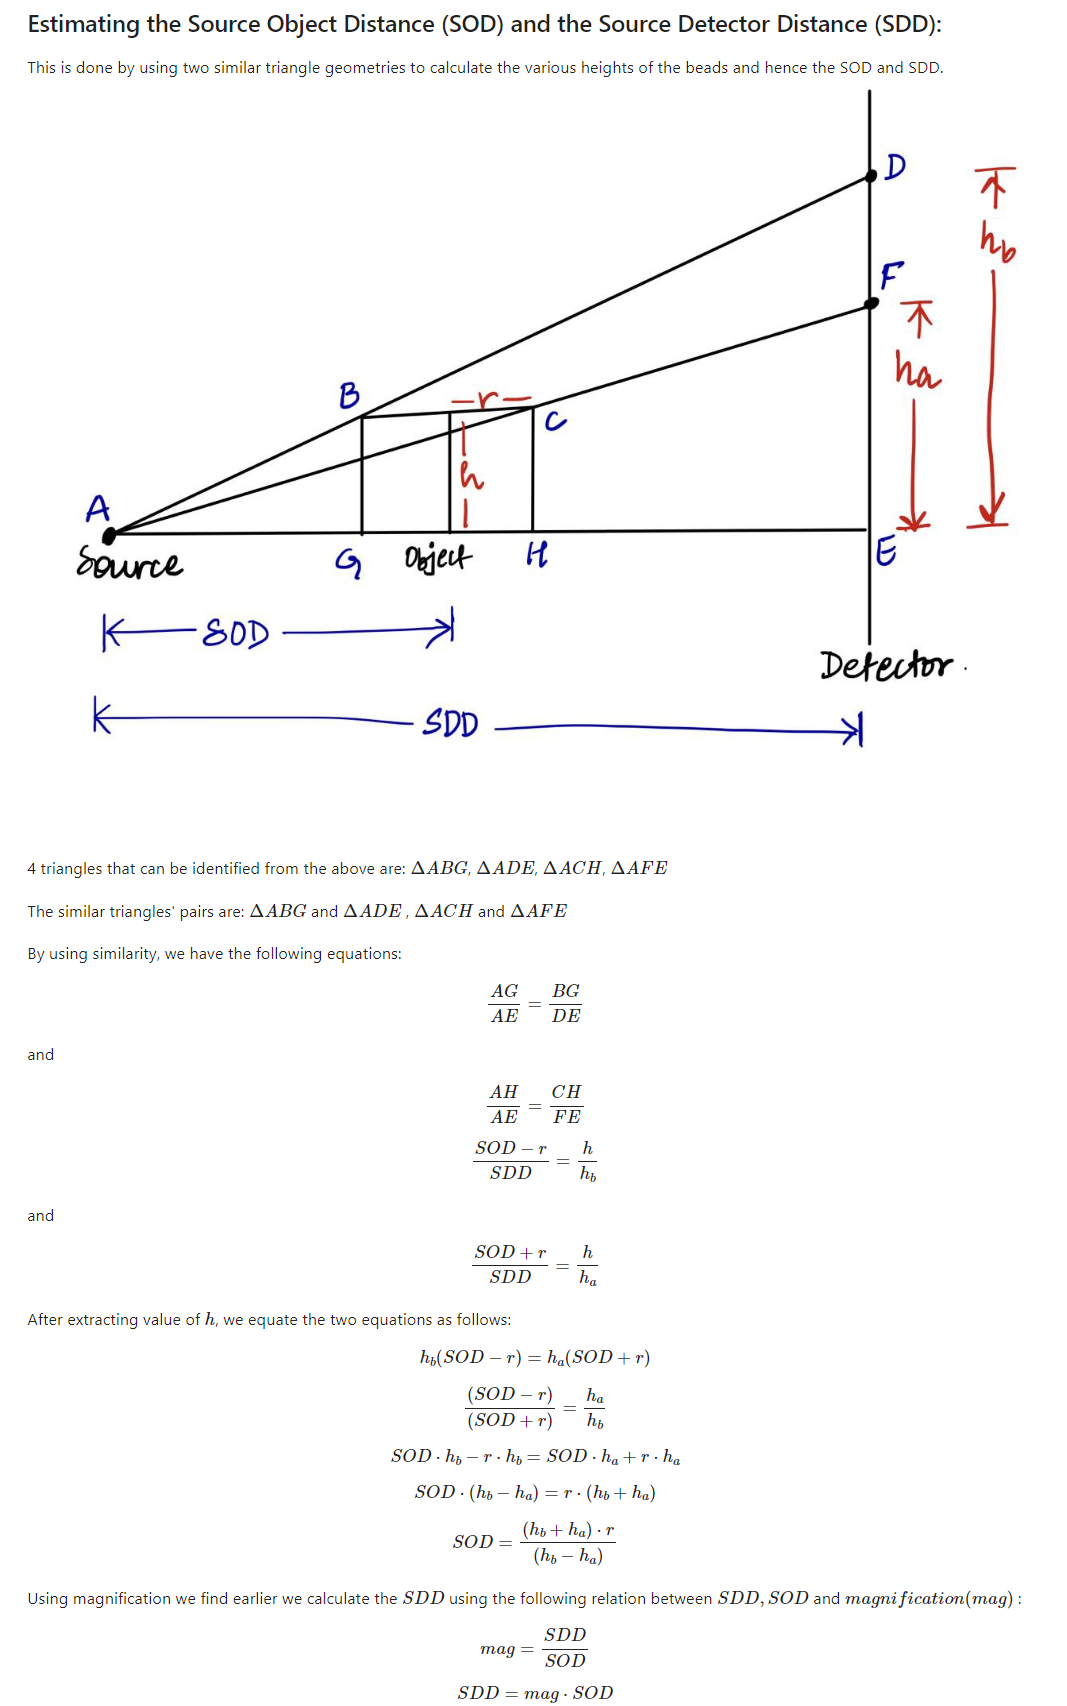

# New calibration sample sketch

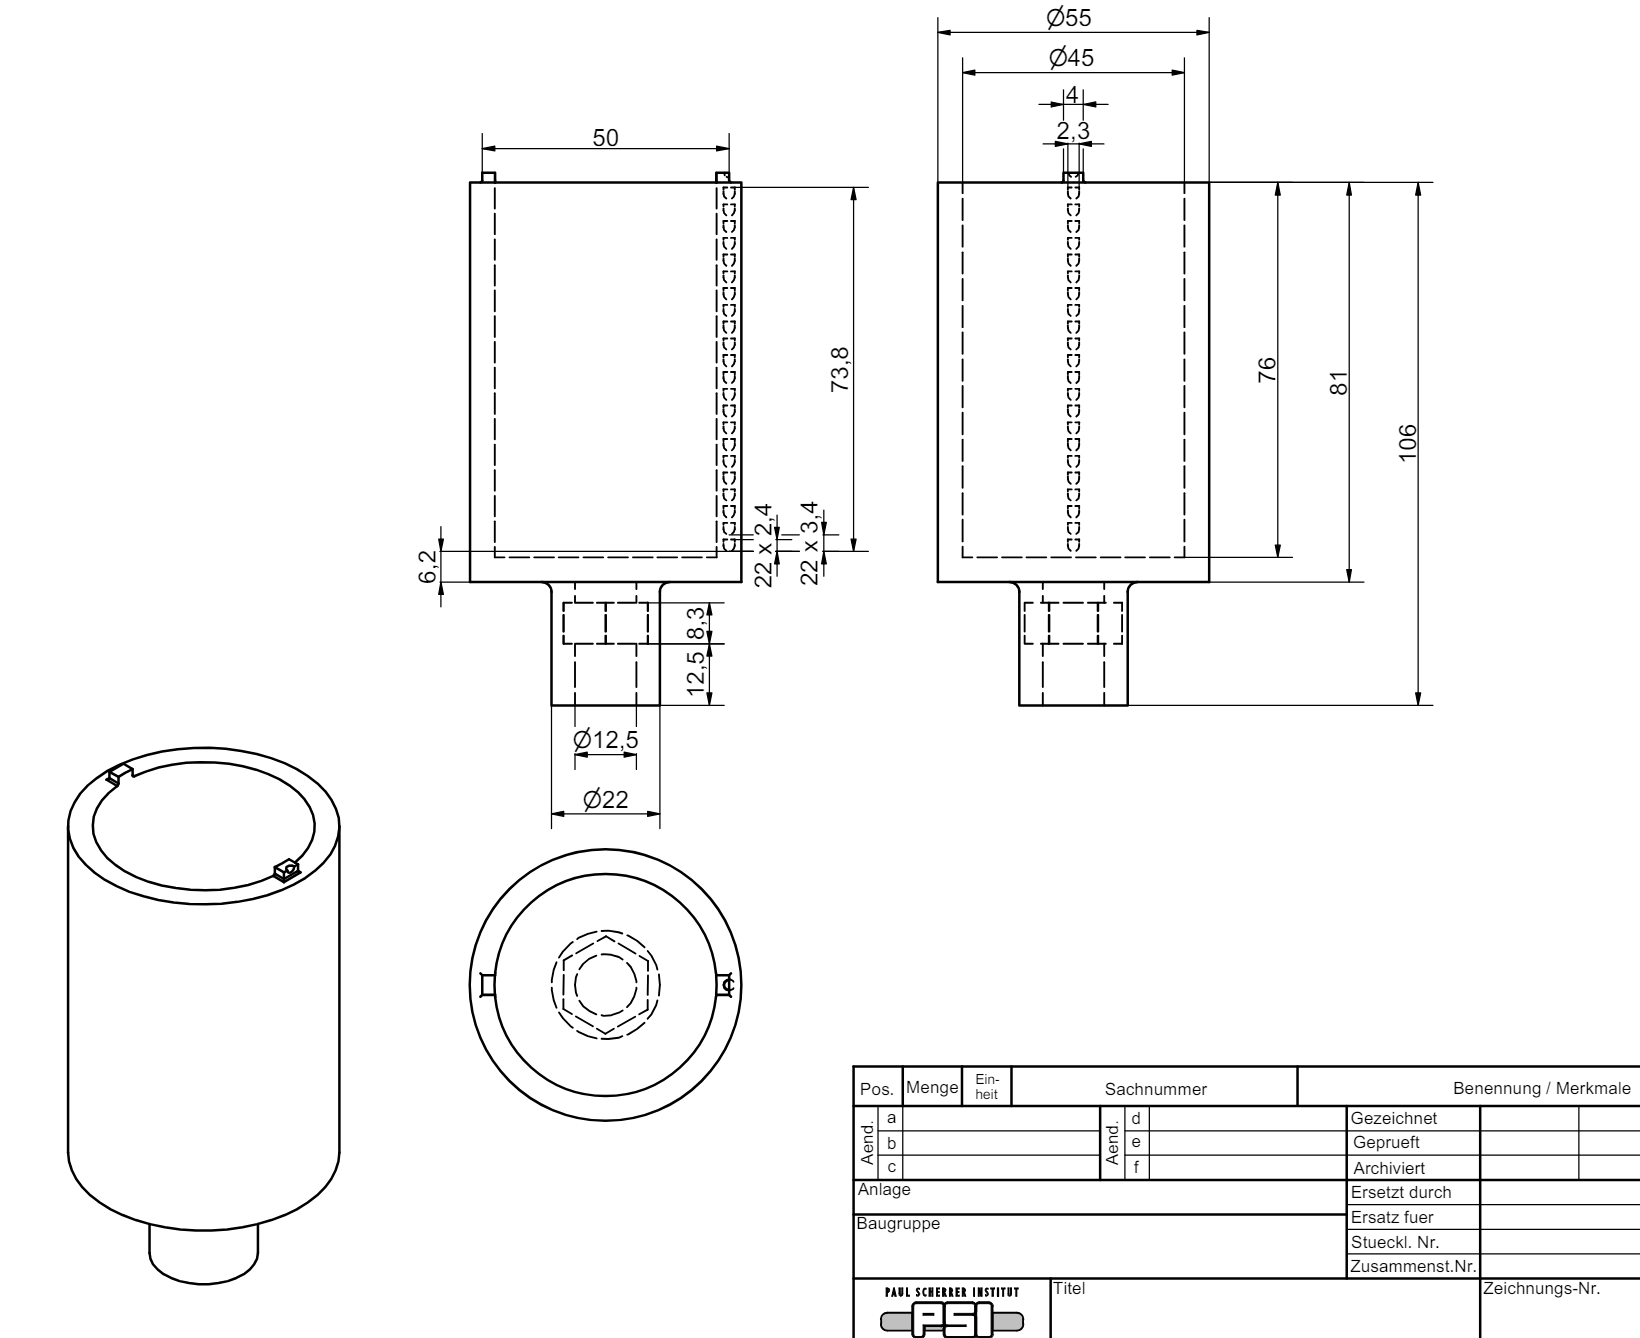